<a href="https://colab.research.google.com/github/wko1014/GAN_Study/blob/main/notes/sGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import time
import os

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
x_height, x_width = [28, 28]
num_channels = 1
num_classes = 10
latent_size = 100
labeled_rate = 0.1

log_path = './SSL_GAN_log.csv'
model_path ='./SSL_GAN_model.ckpt'

In [ ]:
def normalize(x):
    # normalize data
    x = (x - 127.5) / 127.5
    return x.reshape((-1, x_height, x_width, 1))

In [ ]:
 def get_data():
    # MNIST data
    mnist_data = input_data.read_data_sets('mnist_data', one_hot = True)
    return mnist_data

In [ ]:
def D(x, dropout_rate, is_training, reuse = True, print_summary = True):
    # discriminator (x -> n + 1 class)

    with tf.variable_scope('Discriminator', reuse = reuse) as scope:
        # layer1 - do not use Batch Normalization on the first layer of Discriminator
        conv1 = tf.layers.conv2d(x, 32, [5, 5],
                                 strides = [2, 2],
                                 padding = 'same')
        lrelu1 = tf.maximum(0.2 * conv1, conv1) #leaky relu
        dropout1 = tf.layers.dropout(lrelu1, dropout_rate)

        # layer2
        conv2 = tf.layers.conv2d(dropout1, 64, [3, 3],
                                 strides = [2, 2],
                                 padding = 'same')
        batch_norm2 = tf.layers.batch_normalization(conv2, training = is_training)
        lrelu2 = tf.maximum(0.2 * batch_norm2, batch_norm2)

        # layer3
        conv3 = tf.layers.conv2d(lrelu2, 128, [2, 2],
                                 strides = [2, 2],
                                 padding = 'same')
        batch_norm3 = tf.layers.batch_normalization(conv3, training = is_training)
        lrelu3 = tf.maximum(0.2 * batch_norm3, batch_norm3)
        dropout3 = tf.layers.dropout(lrelu3, dropout_rate)

        # layer 4
        conv4 = tf.layers.conv2d(dropout3, 128, [2, 2],
                                 strides = [2, 2],
                                 padding = 'same')
        # do not use batch_normalization on this layer - next layer, "flatten5",
        # will be used for "Feature Matching"
        lrelu4 = tf.maximum(0.2 * conv4, conv4)

        # layer 5
        flatten_length = lrelu4.get_shape().as_list()[1] * \
                         lrelu4.get_shape().as_list()[2] * lrelu4.get_shape().as_list()[3]
        flatten5 = tf.reshape(lrelu4, (-1, flatten_length)) # used for "Feature Matching" 
        fc5 = tf.layers.dense(flatten5, (num_classes + 1))
        output = tf.nn.softmax(fc5)

        assert output.get_shape()[1:] == [num_classes + 1]

        if print_summary:
            print('Discriminator summary:\n x: %s\n' \
                  ' D1: %s\n D2: %s\n D3: %s\n D4: %s\n' %(x.get_shape(), 
                                                           dropout1.get_shape(),
                                                           lrelu2.get_shape(), 
                                                           dropout3.get_shape(),
                                                           lrelu4.get_shape()))
        return flatten5, fc5, output

In [ ]:
def G(z, is_training, reuse = False, print_summary = False):
    # generator (z -> x)

    with tf.variable_scope('Generator', reuse = reuse) as scope:
        # layer 0
        z_reshaped = tf.reshape(z, [-1, 1, 1, latent_size])

        # layer 1
        deconv1 = tf.layers.conv2d_transpose(z_reshaped,
                                             filters = latent_size,
                                             kernel_size = [2, 2],
                                             strides = [1, 1],
                                             padding = 'valid')
        batch_norm1 = tf.layers.batch_normalization(deconv1, training = is_training)
        relu1 = tf.nn.relu(batch_norm1)

        # layer 2
        deconv2 = tf.layers.conv2d_transpose(relu1,
                                             filters = 64,
                                             kernel_size = [3, 3],
                                             strides = [2, 2],
                                             padding = 'valid')
        batch_norm2 = tf.layers.batch_normalization(deconv2, training = is_training)
        relu2 = tf.nn.relu(batch_norm2)

        # layer 3
        deconv3 = tf.layers.conv2d_transpose(relu2,
                                             filters = 32,
                                             kernel_size = [4, 4],
                                             strides = [2, 2],
                                             padding = 'valid')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training = is_training)
        relu3 = tf.nn.relu(batch_norm3)

        # layer 4 - do not use Batch Normalization on the last layer of Generator
        deconv4 = tf.layers.conv2d_transpose(relu3,
                                             filters = num_channels,
                                             kernel_size = [6, 6],
                                             strides = [2, 2],
                                             padding = 'valid')
        tanh4 = tf.tanh(deconv4)

        assert tanh4.get_shape()[1:] == [x_height, x_width, num_channels]
        if print_summary:
            print('Generator summary:\n z: %s\n' \
                  ' G0: %s\n G1: %s\n G2: %s\n G3: %s\n G4: %s\n' %(z.get_shape(),
                                                                    z_reshaped.get_shape(),
                                                                    relu1.get_shape(),
                                                                    relu2.get_shape(),
                                                                    relu3.get_shape(),
                                                                    tanh4.get_shape()))
        return tanh4

In [ ]:
def build_model(x_real, z, label, dropout_rate, is_training, print_summary = False):
    # build model
    D_real_features, D_real_logit, D_real_prob = D(x_real, dropout_rate, is_training,
                                                   reuse = False, print_summary = print_summary)
    x_fake = G(z, is_training, reuse = False, print_summary = print_summary)
    D_fake_features, D_fake_logit, D_fake_prob = D(x_fake, dropout_rate, is_training,
                                                   reuse = True, print_summary = print_summary)

    return D_real_features, D_real_logit, D_real_prob, D_fake_features, D_fake_logit, D_fake_prob, x_fake

In [ ]:
def prepare_labels(label):
    # add extra label for fake data
    extended_label = tf.concat([label, tf.zeros([tf.shape(label)[0], 1])], axis = 1)

    return extended_label

In [ ]:
def loss_accuracy(D_real_features, D_real_logit, D_real_prob, D_fake_features,
                  D_fake_logit, D_fake_prob, extended_label, labeled_mask):
    epsilon = 1e-8 # used to avoid NAN loss
    # *** Discriminator loss ***
    # supervised loss
    # which class the real data belongs to
    tmp = tf.nn.softmax_cross_entropy_with_logits(logits = D_real_logit,
                                                  labels = extended_label)
    D_L_supervised = tf.reduce_sum(labeled_mask * tmp) / tf.reduce_sum(labeled_mask) # to ignore
                                                                                     # unlabeled
                                                                                     # data

    # unsupervised loss
    # data is real
    prob_real_be_real = 1 - D_real_prob[:, -1] + epsilon
    tmp_log = tf.log(prob_real_be_real)
    D_L_unsupervised1 = -1 * tf.reduce_mean(tmp_log)

    # data is fake
    prob_fake_be_fake = D_fake_prob[:, -1] + epsilon
    tmp_log = tf.log(prob_fake_be_fake)
    D_L_unsupervised2 = -1 * tf.reduce_mean(tmp_log)

    D_L = D_L_supervised + D_L_unsupervised1 + D_L_unsupervised2

    # *** Generator loss ***
    # fake data is mistaken to be real
    prob_fake_be_real = 1 - D_fake_prob[:, -1] + epsilon
    tmp_log =  tf.log(prob_fake_be_real)
    G_L1 = -1 * tf.reduce_mean(tmp_log)

    # Feature Maching
    tmp1 = tf.reduce_mean(D_real_features, axis = 0)
    tmp2 = tf.reduce_mean(D_fake_features, axis = 0)
    G_L2 = tf.reduce_mean(tf.square(tmp1 - tmp2))

    G_L = G_L1 + G_L2

    # accuracy
    correct_prediction = tf.equal(tf.argmax(D_real_prob[:, :-1], 1),
                                  tf.argmax(extended_label[:, :-1], 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    return D_L_supervised, D_L_unsupervised1, D_L_unsupervised2, D_L, G_L, accuracy

In [ ]:
def optimizer(D_Loss, G_Loss, D_learning_rate, G_learning_rate):
    # D and G optimizer
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        all_vars = tf.trainable_variables()
        D_vars = [var for var in all_vars if var.name.startswith('Discriminator')]
        G_vars = [var for var in all_vars if var.name.startswith('Generator')]

        D_optimizer = tf.train.AdamOptimizer(D_learning_rate).minimize(D_Loss, var_list = D_vars)
        G_optimizer = tf.train.AdamOptimizer(G_learning_rate).minimize(G_Loss, var_list = G_vars)
        return D_optimizer, G_optimizer

In [ ]:
def plot_fake_data(data, grid_size = [5, 5]):
    # visualize some data generated by G
    _, axes = plt.subplots(figsize = grid_size, nrows = grid_size[0], ncols = grid_size[1],
                           sharey = True, sharex = True)

    size = grid_size[0] * grid_size[1]
    index = np.int_(np.random.uniform(0, data.shape[0], size = (size)))
    figs = data[index].reshape(-1, x_height, x_width)

    for idx, ax in enumerate(axes.flatten()):
        ax.axis('off')
        ax.imshow(figs[idx], cmap = 'gray')
    plt.tight_layout()
    plt.show()

In [ ]:
def save_model_on_imporvemnet(file_path, sess, cv_acc, cv_accs):
  #  # save model when there is improvemnet in cv_acc value
    if cv_accs == [] or cv_acc > np.max(cv_accs):
        saver = tf.train.Saver(max_to_keep = 1)
        saver.save(sess, file_path)
        print('Model saved')
    print('')

In [ ]:
def get_labled_mask(labeled_rate, batch_size):
    # get labeled mask to mask some data unlabeled
    labeled_mask = np.zeros([batch_size], dtype = np.float32)
    labeled_count = np.int(batch_size * labeled_rate)
    labeled_mask[range(labeled_count)] = 1.0
    #np.random.shuffle(labeled_mask)

    return labeled_mask

In [ ]:
def log_loss_acc(file_path, epoch, train_loss_D, train_loss_G, train_Acc,
                 cv_loss_D, cv_loss_G, cv_Acc, log_mode = 'a'):
    # log train and cv losses as well as accuracy
    mode = log_mode if epoch == 0 else 'a'

    with open(file_path, mode) as f:
        if mode == 'w':
            header = 'epoch, train_loss_D, train_loss_G,' \
                     'train_Acc, cv_loss_D, cv_loss_G, cv_Acc\n'
            f.write(header)

        line = '%d, %f, %f, %f, %f, %f, %f\n' %(epoch, train_loss_D, train_loss_G, train_Acc,
                                                cv_loss_D, cv_loss_G, cv_Acc)
        f.write(line)

In [ ]:
def train_SSL_GAN(batch_size, epochs):
    # train Semi-Supervised Learning GAN
    train_D_losses, train_G_losses, train_Accs = [], [], []
    cv_D_losses, cv_G_losses, cv_Accs = [], [], []

    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, name = 'x', shape = [None, x_height, x_width, num_channels])
    label = tf.placeholder(tf.float32, name = 'label', shape = [None, num_classes])
    labeled_mask = tf.placeholder(tf.float32, name = 'labeled_mask', shape = [None])
    z = tf.placeholder(tf.float32, name = 'z', shape = [None, latent_size])
    dropout_rate = tf.placeholder(tf.float32, name = 'dropout_rate')
    is_training = tf.placeholder(tf.bool, name = 'is_training')
    G_learning_rate = tf.placeholder(tf.float32, name = 'G_learning_rate')
    D_learning_rate = tf.placeholder(tf.float32, name = 'D_learning_rate')

    model = build_model(x, z, label, dropout_rate, is_training, print_summary = True)
    D_real_features, D_real_logit, D_real_prob, D_fake_features, D_fake_logit, D_fake_prob, fake_data = model
    extended_label = prepare_labels(label)
    loss_acc  = loss_accuracy(D_real_features, D_real_logit, D_real_prob,
                              D_fake_features, D_fake_logit, D_fake_prob,
                              extended_label, labeled_mask)
    _, _, _, D_L, G_L, accuracy = loss_acc
    D_optimizer, G_optimizer = optimizer(D_L, G_L, G_learning_rate, D_learning_rate)

    print('training....')

    with tf.Session() as sess:       
        sess.run(tf.global_variables_initializer())
        mnist_set = get_data()

        for epoch in range(epochs):
            t_total = 0
            for iter in range(int(mnist_set.train.images.shape[0] / batch_size) + 1):
                t_start = time.time()
                batch = mnist_set.train.next_batch(batch_size, shuffle = False)
                batch_z = np.random.uniform(-1.0, 1.0, size = (batch_size, latent_size))
                mask = get_labled_mask(labeled_rate, batch_size)
                train_feed_dictionary = {x:  normalize(batch[0]),
                                         z: batch_z,
                                         label: batch[1],
                                         labeled_mask: mask,
                                         dropout_rate: 0.5,
                                         G_learning_rate: 1e-5,
                                         D_learning_rate: 1e-5,
                                         is_training: True}

                D_optimizer.run(feed_dict = train_feed_dictionary)
                G_optimizer.run(feed_dict = train_feed_dictionary)

                train_D_loss = D_L.eval(feed_dict = train_feed_dictionary)
                train_G_loss = G_L.eval(feed_dict = train_feed_dictionary)
                train_accuracy = accuracy.eval(feed_dict = train_feed_dictionary)
                t_total += (time.time() - t_start)

                print('epoch: %d, time: %f | train_G_Loss: %f, ' \
                      'train_D_loss: %f, train_acc: %f' %(epoch, t_total,
                                                          train_G_loss, train_D_loss,
                                                          train_accuracy), end = '\r')
            train_D_losses.append(train_D_loss)
            train_G_losses.append(train_G_loss)
            train_Accs.append(train_accuracy)

            # Cross-Validation
            cv_size = mnist_set.test.labels.shape[0]
            cv_batch_z = np.random.uniform(-1.0, 1.0, size = (cv_size, latent_size))
            mask = get_labled_mask(1, cv_size)
            cv_feed_dictionary = {x: normalize(mnist_set.test.images),
                                  z: cv_batch_z,
                                  label: mnist_set.test.labels,
                                  labeled_mask: mask,
                                  dropout_rate: 0.0,
                                  is_training: False}

            cv_D_loss = D_L.eval(feed_dict = cv_feed_dictionary)
            cv_G_loss = G_L.eval(feed_dict = cv_feed_dictionary)
            cv_accuracy = accuracy.eval(feed_dict = cv_feed_dictionary)

            log_loss_acc(log_path, epoch, train_D_loss, train_G_loss, train_accuracy,
                         cv_D_loss, cv_G_loss, cv_accuracy, log_mode = 'w')
            print('\ncv_G_Loss: %f, cv_D_loss: %f, cv_acc: %f' %(cv_G_loss,
                                                                 cv_D_loss,
                                                                 cv_accuracy))
            save_model_on_imporvemnet(model_path, sess, cv_accuracy, cv_Accs)
            cv_D_losses.append(cv_D_loss)
            cv_G_losses.append(cv_G_loss)
            cv_Accs.append(cv_accuracy)

            if epoch % 10 == 0:
                fakes = fake_data.eval(feed_dict = cv_feed_dictionary)
                plot_fake_data(fakes, [5, 5])

    return train_D_losses, train_G_losses, train_Accs, cv_D_losses, cv_G_losses, cv_Accs

Discriminator summary:
 x: (?, 28, 28, 1)
 D1: (?, 14, 14, 32)
 D2: (?, 7, 7, 64)
 D3: (?, 4, 4, 128)
 D4: (?, 2, 2, 128)

Generator summary:
 z: (?, 100)
 G0: (?, 1, 1, 100)
 G1: (?, 2, 2, 100)
 G2: (?, 5, 5, 64)
 G3: (?, 12, 12, 32)
 G4: (?, 28, 28, 1)

Discriminator summary:
 x: (?, 28, 28, 1)
 D1: (?, 14, 14, 32)
 D2: (?, 7, 7, 64)
 D3: (?, 4, 4, 128)
 D4: (?, 2, 2, 128)

training....
Extracting mnist_data\train-images-idx3-ubyte.gz
Extracting mnist_data\train-labels-idx1-ubyte.gz
Extracting mnist_data\t10k-images-idx3-ubyte.gz
Extracting mnist_data\t10k-labels-idx1-ubyte.gz
epoch: 0, time: 10.777711 | train_G_Loss: 0.548105, train_D_loss: 3.702818, train_acc: 0.076172
cv_G_Loss: 0.313204, cv_D_loss: 4.702096, cv_acc: 0.103200
Model saved



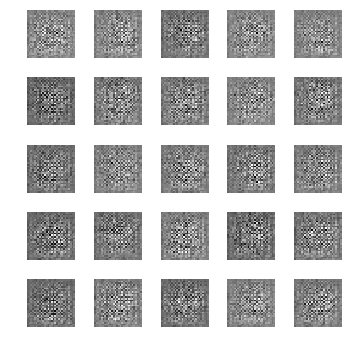

epoch: 1, time: 9.411004 | train_G_Loss: 1.055815, train_D_loss: 2.999887, train_acc: 0.109375
cv_G_Loss: 1.829599, cv_D_loss: 6.787202, cv_acc: 0.103200

epoch: 2, time: 9.397366 | train_G_Loss: 1.438323, train_D_loss: 2.738945, train_acc: 0.101562
cv_G_Loss: 2.648790, cv_D_loss: 8.820969, cv_acc: 0.103200

epoch: 3, time: 9.389836 | train_G_Loss: 1.786475, train_D_loss: 2.613949, train_acc: 0.097656
cv_G_Loss: 3.377611, cv_D_loss: 9.627871, cv_acc: 0.103200

epoch: 4, time: 9.449646 | train_G_Loss: 1.997471, train_D_loss: 2.551313, train_acc: 0.097656
cv_G_Loss: 4.407537, cv_D_loss: 11.356128, cv_acc: 0.098000

epoch: 5, time: 9.232384 | train_G_Loss: 2.466361, train_D_loss: 2.477531, train_acc: 0.111328
cv_G_Loss: 4.761891, cv_D_loss: 13.349782, cv_acc: 0.098000

epoch: 6, time: 9.371879 | train_G_Loss: 2.709965, train_D_loss: 2.421318, train_acc: 0.119141
cv_G_Loss: 4.738748, cv_D_loss: 15.462008, cv_acc: 0.098000

epoch: 7, time: 9.461064 | train_G_Loss: 2.750601, train_D_loss: 2.

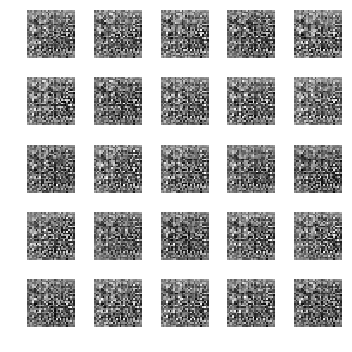

epoch: 11, time: 9.514726 | train_G_Loss: 3.287031, train_D_loss: 2.359741, train_acc: 0.115234
cv_G_Loss: 6.594163, cv_D_loss: 24.510319, cv_acc: 0.098000

epoch: 12, time: 9.218582 | train_G_Loss: 3.583446, train_D_loss: 2.344086, train_acc: 0.107422
cv_G_Loss: 7.215861, cv_D_loss: 26.165787, cv_acc: 0.098000

epoch: 13, time: 9.544870 | train_G_Loss: 3.717212, train_D_loss: 2.357404, train_acc: 0.142578
cv_G_Loss: 7.422676, cv_D_loss: 27.663887, cv_acc: 0.098000

epoch: 14, time: 9.340343 | train_G_Loss: 3.841318, train_D_loss: 2.352145, train_acc: 0.126953
cv_G_Loss: 8.077757, cv_D_loss: 29.527243, cv_acc: 0.098000

epoch: 15, time: 9.400659 | train_G_Loss: 3.963129, train_D_loss: 2.312770, train_acc: 0.119141
cv_G_Loss: 8.655212, cv_D_loss: 31.515659, cv_acc: 0.098000

epoch: 16, time: 9.009238 | train_G_Loss: 3.977378, train_D_loss: 2.330879, train_acc: 0.109375
cv_G_Loss: 9.483811, cv_D_loss: 33.862190, cv_acc: 0.089200

epoch: 17, time: 8.827142 | train_G_Loss: 4.052712, train_

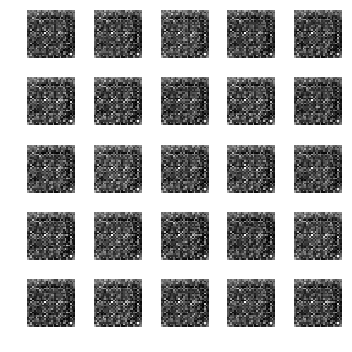

epoch: 21, time: 9.619567 | train_G_Loss: 3.912051, train_D_loss: 2.315933, train_acc: 0.095703
cv_G_Loss: 6.092137, cv_D_loss: 28.519161, cv_acc: 0.103200

epoch: 22, time: 9.354829 | train_G_Loss: 3.947526, train_D_loss: 2.324973, train_acc: 0.105469
cv_G_Loss: 5.055440, cv_D_loss: 28.765827, cv_acc: 0.103200

epoch: 23, time: 9.567018 | train_G_Loss: 3.817235, train_D_loss: 2.346838, train_acc: 0.091797
cv_G_Loss: 4.175282, cv_D_loss: 30.254593, cv_acc: 0.103200
Model saved

epoch: 24, time: 9.433752 | train_G_Loss: 3.823937, train_D_loss: 2.344602, train_acc: 0.199219
cv_G_Loss: 3.649909, cv_D_loss: 31.052361, cv_acc: 0.103200

epoch: 25, time: 9.224821 | train_G_Loss: 3.741686, train_D_loss: 2.340161, train_acc: 0.232422
cv_G_Loss: 3.373365, cv_D_loss: 30.368872, cv_acc: 0.102800

epoch: 26, time: 9.441351 | train_G_Loss: 3.526596, train_D_loss: 2.343862, train_acc: 0.208984
cv_G_Loss: 2.489301, cv_D_loss: 29.862629, cv_acc: 0.097600

epoch: 27, time: 9.486819 | train_G_Loss: 3.39

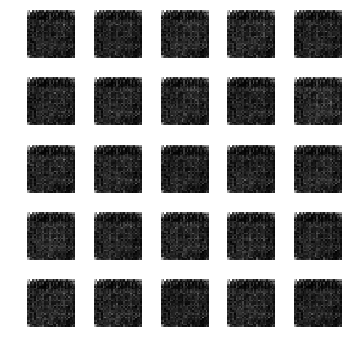

epoch: 31, time: 9.535675 | train_G_Loss: 3.016847, train_D_loss: 2.390976, train_acc: 0.138672
cv_G_Loss: 2.225794, cv_D_loss: 26.293768, cv_acc: 0.103200

epoch: 32, time: 9.541256 | train_G_Loss: 2.845998, train_D_loss: 2.389138, train_acc: 0.269531
cv_G_Loss: 2.198123, cv_D_loss: 25.129189, cv_acc: 0.134500
Model saved

epoch: 33, time: 9.496610 | train_G_Loss: 2.719556, train_D_loss: 2.370513, train_acc: 0.185547
cv_G_Loss: 1.897022, cv_D_loss: 24.494190, cv_acc: 0.132900

epoch: 34, time: 9.472668 | train_G_Loss: 2.554331, train_D_loss: 2.416106, train_acc: 0.332031
cv_G_Loss: 1.563291, cv_D_loss: 20.031425, cv_acc: 0.156600
Model saved

epoch: 35, time: 9.578535 | train_G_Loss: 2.289571, train_D_loss: 2.474078, train_acc: 0.238281
cv_G_Loss: 1.392912, cv_D_loss: 19.116789, cv_acc: 0.127100

epoch: 36, time: 9.220104 | train_G_Loss: 2.145311, train_D_loss: 2.531705, train_acc: 0.189453
cv_G_Loss: 1.230990, cv_D_loss: 19.410866, cv_acc: 0.148300

epoch: 37, time: 9.600763 | train_

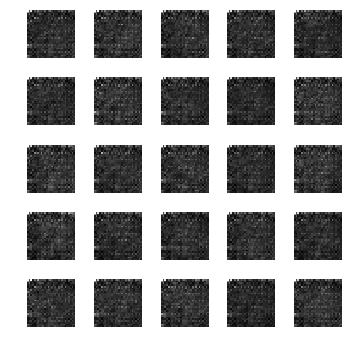

epoch: 41, time: 9.494790 | train_G_Loss: 1.214501, train_D_loss: 2.814225, train_acc: 0.494141
cv_G_Loss: 0.619747, cv_D_loss: 13.501657, cv_acc: 0.139900

epoch: 42, time: 9.302358 | train_G_Loss: 1.245875, train_D_loss: 2.889011, train_acc: 0.333984
cv_G_Loss: 0.706175, cv_D_loss: 15.121858, cv_acc: 0.103000

epoch: 43, time: 9.531732 | train_G_Loss: 1.116366, train_D_loss: 2.952931, train_acc: 0.380859
cv_G_Loss: 0.556560, cv_D_loss: 12.792096, cv_acc: 0.183000
Model saved

epoch: 44, time: 9.450978 | train_G_Loss: 1.091812, train_D_loss: 2.998197, train_acc: 0.414062
cv_G_Loss: 0.514611, cv_D_loss: 12.492462, cv_acc: 0.153000

epoch: 45, time: 9.637421 | train_G_Loss: 1.097398, train_D_loss: 3.064290, train_acc: 0.537109
cv_G_Loss: 0.704623, cv_D_loss: 12.103145, cv_acc: 0.278000
Model saved

epoch: 46, time: 9.565551 | train_G_Loss: 0.794229, train_D_loss: 3.191325, train_acc: 0.453125
cv_G_Loss: 0.440073, cv_D_loss: 11.097254, cv_acc: 0.224300

epoch: 47, time: 9.372422 | train_

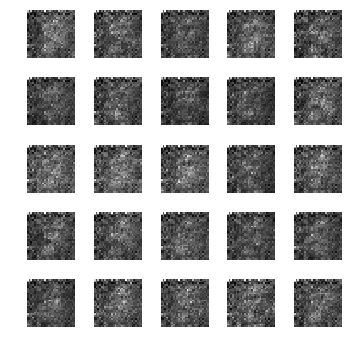

epoch: 51, time: 9.414093 | train_G_Loss: 0.655397, train_D_loss: 3.376745, train_acc: 0.472656
cv_G_Loss: 0.218598, cv_D_loss: 7.567022, cv_acc: 0.373400

epoch: 52, time: 9.435728 | train_G_Loss: 0.739118, train_D_loss: 3.410986, train_acc: 0.583984
cv_G_Loss: 0.547484, cv_D_loss: 8.810219, cv_acc: 0.266800

epoch: 53, time: 9.494030 | train_G_Loss: 0.510042, train_D_loss: 3.372902, train_acc: 0.556641
cv_G_Loss: 0.120039, cv_D_loss: 6.291889, cv_acc: 0.574900
Model saved

epoch: 54, time: 9.608935 | train_G_Loss: 0.593941, train_D_loss: 3.415054, train_acc: 0.535156
cv_G_Loss: 0.108892, cv_D_loss: 6.376345, cv_acc: 0.511500

epoch: 55, time: 9.470093 | train_G_Loss: 0.607177, train_D_loss: 3.370151, train_acc: 0.605469
cv_G_Loss: 0.231820, cv_D_loss: 6.221010, cv_acc: 0.584000
Model saved

epoch: 56, time: 9.188272 | train_G_Loss: 0.614158, train_D_loss: 3.343494, train_acc: 0.572266
cv_G_Loss: 0.213100, cv_D_loss: 6.136821, cv_acc: 0.461200

epoch: 57, time: 9.368444 | train_G_Loss

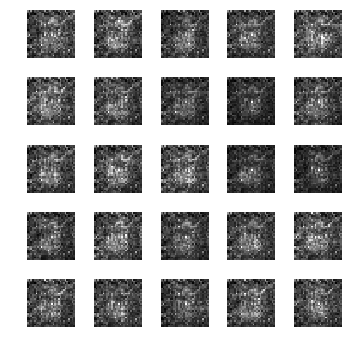

epoch: 61, time: 9.488860 | train_G_Loss: 0.647261, train_D_loss: 3.292185, train_acc: 0.628906
cv_G_Loss: 0.204585, cv_D_loss: 5.220035, cv_acc: 0.479900

epoch: 62, time: 9.627174 | train_G_Loss: 0.618492, train_D_loss: 3.343504, train_acc: 0.662109
cv_G_Loss: 0.122176, cv_D_loss: 4.831624, cv_acc: 0.642800
Model saved

epoch: 63, time: 9.539795 | train_G_Loss: 0.774200, train_D_loss: 3.401478, train_acc: 0.591797
cv_G_Loss: 0.862590, cv_D_loss: 6.386850, cv_acc: 0.559400

epoch: 64, time: 9.452515 | train_G_Loss: 0.565944, train_D_loss: 3.312169, train_acc: 0.626953
cv_G_Loss: 0.182023, cv_D_loss: 4.649922, cv_acc: 0.558400

epoch: 65, time: 9.403087 | train_G_Loss: 0.597448, train_D_loss: 3.334794, train_acc: 0.613281
cv_G_Loss: 0.186443, cv_D_loss: 4.590017, cv_acc: 0.584500

epoch: 66, time: 9.388008 | train_G_Loss: 0.540737, train_D_loss: 3.288803, train_acc: 0.648438
cv_G_Loss: 0.297616, cv_D_loss: 4.478218, cv_acc: 0.666100
Model saved

epoch: 67, time: 9.618411 | train_G_Loss

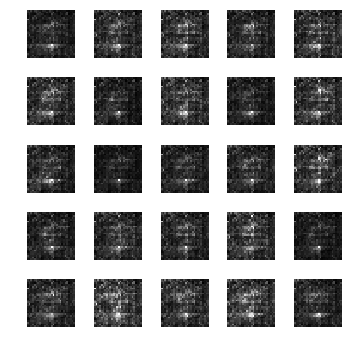

epoch: 71, time: 9.487660 | train_G_Loss: 0.496595, train_D_loss: 3.356443, train_acc: 0.699219
cv_G_Loss: 0.329471, cv_D_loss: 4.157323, cv_acc: 0.642800

epoch: 72, time: 9.557657 | train_G_Loss: 0.597051, train_D_loss: 3.172351, train_acc: 0.593750
cv_G_Loss: 0.132233, cv_D_loss: 4.470273, cv_acc: 0.639400

epoch: 73, time: 9.589453 | train_G_Loss: 0.556690, train_D_loss: 3.286243, train_acc: 0.585938
cv_G_Loss: 0.096458, cv_D_loss: 4.663747, cv_acc: 0.541200

epoch: 74, time: 9.410553 | train_G_Loss: 0.476303, train_D_loss: 3.172604, train_acc: 0.687500
cv_G_Loss: 1.029727, cv_D_loss: 5.297581, cv_acc: 0.677200
Model saved

epoch: 75, time: 9.510224 | train_G_Loss: 0.545215, train_D_loss: 3.150515, train_acc: 0.623047
cv_G_Loss: 0.430590, cv_D_loss: 4.008976, cv_acc: 0.667900

epoch: 76, time: 9.531059 | train_G_Loss: 0.620697, train_D_loss: 3.093866, train_acc: 0.671875
cv_G_Loss: 0.291141, cv_D_loss: 3.770342, cv_acc: 0.673700

epoch: 77, time: 9.520315 | train_G_Loss: 0.564773, 

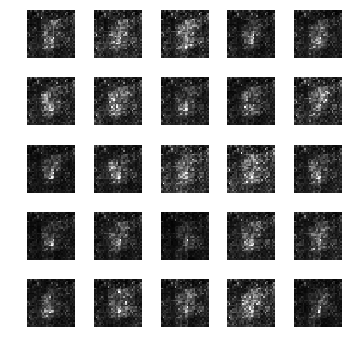

epoch: 81, time: 9.639839 | train_G_Loss: 0.547716, train_D_loss: 2.993949, train_acc: 0.648438
cv_G_Loss: 0.156468, cv_D_loss: 4.010331, cv_acc: 0.469200

epoch: 82, time: 9.444799 | train_G_Loss: 0.583855, train_D_loss: 3.020647, train_acc: 0.695312
cv_G_Loss: 0.652634, cv_D_loss: 3.277000, cv_acc: 0.628700

epoch: 83, time: 9.399478 | train_G_Loss: 0.564666, train_D_loss: 2.785302, train_acc: 0.662109
cv_G_Loss: 0.112354, cv_D_loss: 4.085861, cv_acc: 0.612000

epoch: 84, time: 9.389262 | train_G_Loss: 0.598827, train_D_loss: 2.988052, train_acc: 0.636719
cv_G_Loss: 1.376850, cv_D_loss: 4.418936, cv_acc: 0.700100

epoch: 85, time: 9.404786 | train_G_Loss: 0.410855, train_D_loss: 3.293405, train_acc: 0.666016
cv_G_Loss: 0.048466, cv_D_loss: 4.937660, cv_acc: 0.610700

epoch: 86, time: 9.544213 | train_G_Loss: 0.504378, train_D_loss: 2.916859, train_acc: 0.685547
cv_G_Loss: 0.446005, cv_D_loss: 3.489354, cv_acc: 0.727000
Model saved

epoch: 87, time: 9.650561 | train_G_Loss: 0.610560, 

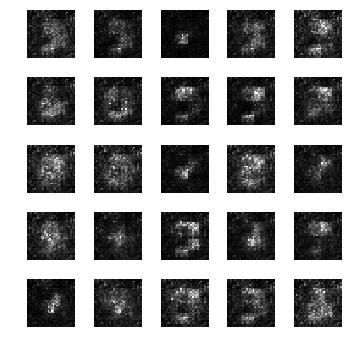

epoch: 91, time: 9.557697 | train_G_Loss: 0.418630, train_D_loss: 3.144502, train_acc: 0.740234
cv_G_Loss: 0.226632, cv_D_loss: 3.407551, cv_acc: 0.739200
Model saved

epoch: 92, time: 9.665443 | train_G_Loss: 0.503948, train_D_loss: 3.078678, train_acc: 0.693359
cv_G_Loss: 0.208427, cv_D_loss: 3.471493, cv_acc: 0.742600
Model saved

epoch: 93, time: 9.448669 | train_G_Loss: 0.523344, train_D_loss: 3.146504, train_acc: 0.697266
cv_G_Loss: 0.319808, cv_D_loss: 3.339212, cv_acc: 0.702200

epoch: 94, time: 9.331703 | train_G_Loss: 0.574278, train_D_loss: 2.780503, train_acc: 0.789062
cv_G_Loss: 0.427834, cv_D_loss: 3.240800, cv_acc: 0.746600
Model saved

epoch: 95, time: 9.519939 | train_G_Loss: 0.487087, train_D_loss: 2.811935, train_acc: 0.751953
cv_G_Loss: 0.323634, cv_D_loss: 3.285388, cv_acc: 0.714200

epoch: 96, time: 9.474015 | train_G_Loss: 0.443049, train_D_loss: 3.015948, train_acc: 0.767578
cv_G_Loss: 0.251945, cv_D_loss: 3.297476, cv_acc: 0.747000
Model saved

epoch: 97, time:

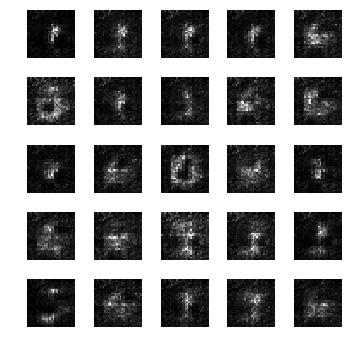

epoch: 101, time: 9.511555 | train_G_Loss: 0.365480, train_D_loss: 2.984081, train_acc: 0.757812
cv_G_Loss: 0.063535, cv_D_loss: 4.172769, cv_acc: 0.740700

epoch: 102, time: 9.471186 | train_G_Loss: 0.456918, train_D_loss: 2.833264, train_acc: 0.785156
cv_G_Loss: 0.528296, cv_D_loss: 3.148392, cv_acc: 0.743700

epoch: 103, time: 9.386189 | train_G_Loss: 0.435660, train_D_loss: 2.796737, train_acc: 0.759766
cv_G_Loss: 0.162104, cv_D_loss: 3.479960, cv_acc: 0.738500

epoch: 104, time: 9.499226 | train_G_Loss: 0.418474, train_D_loss: 3.014960, train_acc: 0.742188
cv_G_Loss: 0.364658, cv_D_loss: 3.031861, cv_acc: 0.764600
Model saved

epoch: 105, time: 9.453758 | train_G_Loss: 0.575579, train_D_loss: 2.853924, train_acc: 0.777344
cv_G_Loss: 0.474149, cv_D_loss: 3.141284, cv_acc: 0.767200
Model saved

epoch: 106, time: 9.524688 | train_G_Loss: 0.507666, train_D_loss: 2.577385, train_acc: 0.806641
cv_G_Loss: 0.817936, cv_D_loss: 3.373728, cv_acc: 0.748400

epoch: 107, time: 9.330500 | train

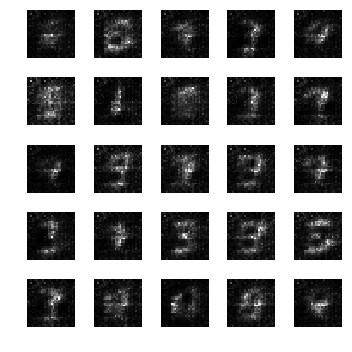

epoch: 111, time: 9.626496 | train_G_Loss: 0.487946, train_D_loss: 2.722287, train_acc: 0.787109
cv_G_Loss: 0.160783, cv_D_loss: 3.454305, cv_acc: 0.766200

epoch: 112, time: 9.357083 | train_G_Loss: 0.394761, train_D_loss: 2.734916, train_acc: 0.798828
cv_G_Loss: 0.193825, cv_D_loss: 3.277785, cv_acc: 0.780500
Model saved

epoch: 113, time: 9.527792 | train_G_Loss: 0.509628, train_D_loss: 2.953181, train_acc: 0.798828
cv_G_Loss: 0.508273, cv_D_loss: 3.067944, cv_acc: 0.781800
Model saved

epoch: 114, time: 9.638201 | train_G_Loss: 0.503077, train_D_loss: 2.891751, train_acc: 0.828125
cv_G_Loss: 0.516202, cv_D_loss: 3.143196, cv_acc: 0.754100

epoch: 115, time: 9.479926 | train_G_Loss: 0.470130, train_D_loss: 2.664175, train_acc: 0.806641
cv_G_Loss: 1.553773, cv_D_loss: 4.720399, cv_acc: 0.745500

epoch: 116, time: 9.394824 | train_G_Loss: 0.385145, train_D_loss: 2.718415, train_acc: 0.765625
cv_G_Loss: 0.458689, cv_D_loss: 3.015675, cv_acc: 0.785400
Model saved

epoch: 117, time: 9.36

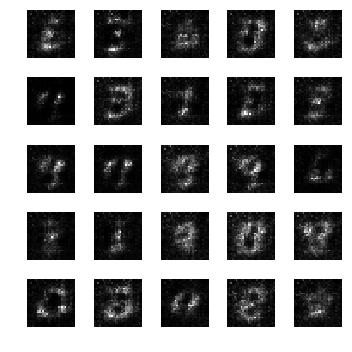

epoch: 121, time: 9.496729 | train_G_Loss: 0.466871, train_D_loss: 2.638710, train_acc: 0.785156
cv_G_Loss: 0.453752, cv_D_loss: 3.036411, cv_acc: 0.766300

epoch: 122, time: 9.511378 | train_G_Loss: 0.300437, train_D_loss: 2.709543, train_acc: 0.765625
cv_G_Loss: 0.505925, cv_D_loss: 2.945499, cv_acc: 0.787900

epoch: 123, time: 9.450718 | train_G_Loss: 0.400710, train_D_loss: 2.826442, train_acc: 0.726562
cv_G_Loss: 0.524338, cv_D_loss: 3.002892, cv_acc: 0.783000

epoch: 124, time: 9.447126 | train_G_Loss: 0.370788, train_D_loss: 3.229266, train_acc: 0.750000
cv_G_Loss: 0.670058, cv_D_loss: 3.085899, cv_acc: 0.778200

epoch: 125, time: 9.535275 | train_G_Loss: 0.513177, train_D_loss: 2.944681, train_acc: 0.753906
cv_G_Loss: 0.821928, cv_D_loss: 3.228101, cv_acc: 0.788100

epoch: 126, time: 9.332906 | train_G_Loss: 0.508754, train_D_loss: 2.876727, train_acc: 0.734375
cv_G_Loss: 0.329910, cv_D_loss: 2.979775, cv_acc: 0.773000

epoch: 127, time: 9.506646 | train_G_Loss: 0.500525, train

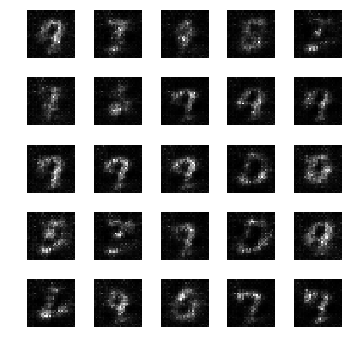

epoch: 131, time: 9.341804 | train_G_Loss: 0.398199, train_D_loss: 2.635375, train_acc: 0.830078
cv_G_Loss: 0.205101, cv_D_loss: 3.005699, cv_acc: 0.793900

epoch: 132, time: 9.496031 | train_G_Loss: 0.518787, train_D_loss: 2.684073, train_acc: 0.767578
cv_G_Loss: 0.237863, cv_D_loss: 2.954031, cv_acc: 0.785300

epoch: 133, time: 9.472825 | train_G_Loss: 0.422327, train_D_loss: 2.952058, train_acc: 0.787109
cv_G_Loss: 0.289304, cv_D_loss: 2.824875, cv_acc: 0.793600

epoch: 134, time: 9.505185 | train_G_Loss: 0.419641, train_D_loss: 2.473442, train_acc: 0.828125
cv_G_Loss: 0.205492, cv_D_loss: 2.991146, cv_acc: 0.783200

epoch: 135, time: 9.534330 | train_G_Loss: 0.540974, train_D_loss: 2.759480, train_acc: 0.794922
cv_G_Loss: 0.466849, cv_D_loss: 2.809170, cv_acc: 0.807300
Model saved

epoch: 136, time: 9.446055 | train_G_Loss: 0.426689, train_D_loss: 2.873589, train_acc: 0.802734
cv_G_Loss: 0.233663, cv_D_loss: 2.951459, cv_acc: 0.793200

epoch: 137, time: 9.575783 | train_G_Loss: 0.5

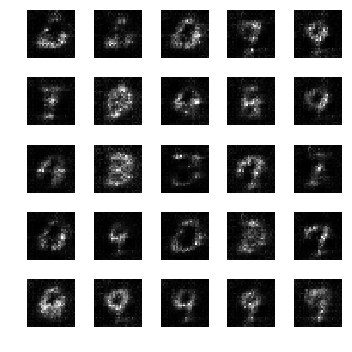

epoch: 141, time: 9.473936 | train_G_Loss: 0.432296, train_D_loss: 2.519418, train_acc: 0.837891
cv_G_Loss: 0.113177, cv_D_loss: 3.345218, cv_acc: 0.806500

epoch: 142, time: 9.698865 | train_G_Loss: 0.493484, train_D_loss: 2.520261, train_acc: 0.792969
cv_G_Loss: 0.579068, cv_D_loss: 2.847257, cv_acc: 0.795100

epoch: 143, time: 9.646353 | train_G_Loss: 0.446368, train_D_loss: 2.681101, train_acc: 0.775391
cv_G_Loss: 0.899713, cv_D_loss: 3.114347, cv_acc: 0.801300

epoch: 144, time: 9.684176 | train_G_Loss: 0.313000, train_D_loss: 2.861014, train_acc: 0.796875
cv_G_Loss: 0.069960, cv_D_loss: 3.737617, cv_acc: 0.783400

epoch: 145, time: 9.591820 | train_G_Loss: 0.405356, train_D_loss: 2.614683, train_acc: 0.832031
cv_G_Loss: 0.356239, cv_D_loss: 2.738216, cv_acc: 0.810300
Model saved

epoch: 146, time: 9.576736 | train_G_Loss: 0.576676, train_D_loss: 2.479254, train_acc: 0.855469
cv_G_Loss: 0.726330, cv_D_loss: 2.879536, cv_acc: 0.812800
Model saved

epoch: 147, time: 9.557683 | train

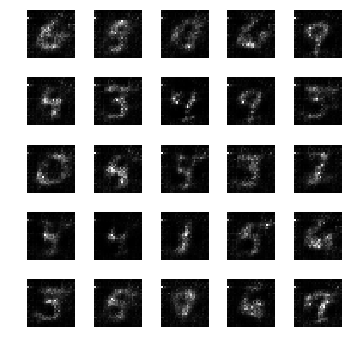

epoch: 151, time: 9.554698 | train_G_Loss: 0.312509, train_D_loss: 3.397799, train_acc: 0.748047
cv_G_Loss: 0.112898, cv_D_loss: 3.376732, cv_acc: 0.783600

epoch: 152, time: 9.452698 | train_G_Loss: 0.530353, train_D_loss: 2.778646, train_acc: 0.794922
cv_G_Loss: 1.078881, cv_D_loss: 3.437545, cv_acc: 0.815500
Model saved

epoch: 153, time: 9.581746 | train_G_Loss: 0.620728, train_D_loss: 2.804891, train_acc: 0.787109
cv_G_Loss: 0.563015, cv_D_loss: 2.945718, cv_acc: 0.801700

epoch: 154, time: 9.740366 | train_G_Loss: 0.358364, train_D_loss: 3.137873, train_acc: 0.763672
cv_G_Loss: 0.555730, cv_D_loss: 2.786052, cv_acc: 0.802600

epoch: 155, time: 9.645639 | train_G_Loss: 0.340332, train_D_loss: 2.810557, train_acc: 0.785156
cv_G_Loss: 0.743397, cv_D_loss: 2.929263, cv_acc: 0.802600

epoch: 156, time: 9.465088 | train_G_Loss: 0.321094, train_D_loss: 2.634200, train_acc: 0.800781
cv_G_Loss: 0.202658, cv_D_loss: 2.950883, cv_acc: 0.800700

epoch: 157, time: 9.545020 | train_G_Loss: 0.4

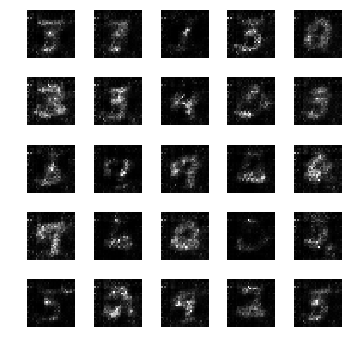

epoch: 161, time: 9.711320 | train_G_Loss: 0.385883, train_D_loss: 2.512018, train_acc: 0.806641
cv_G_Loss: 0.649849, cv_D_loss: 2.969695, cv_acc: 0.803700

epoch: 162, time: 9.627036 | train_G_Loss: 0.373041, train_D_loss: 2.921632, train_acc: 0.789062
cv_G_Loss: 0.272130, cv_D_loss: 2.912073, cv_acc: 0.790400

epoch: 163, time: 9.420185 | train_G_Loss: 0.494339, train_D_loss: 2.708876, train_acc: 0.837891
cv_G_Loss: 0.951275, cv_D_loss: 3.294374, cv_acc: 0.815800
Model saved

epoch: 164, time: 9.652418 | train_G_Loss: 0.458019, train_D_loss: 2.524083, train_acc: 0.830078
cv_G_Loss: 2.475703, cv_D_loss: 5.952594, cv_acc: 0.806200

epoch: 165, time: 9.686022 | train_G_Loss: 0.390103, train_D_loss: 2.755215, train_acc: 0.783203
cv_G_Loss: 0.154226, cv_D_loss: 3.178081, cv_acc: 0.798000

epoch: 166, time: 9.768579 | train_G_Loss: 0.313160, train_D_loss: 2.738570, train_acc: 0.820312
cv_G_Loss: 0.225804, cv_D_loss: 2.953429, cv_acc: 0.796000

epoch: 167, time: 9.600253 | train_G_Loss: 0.3

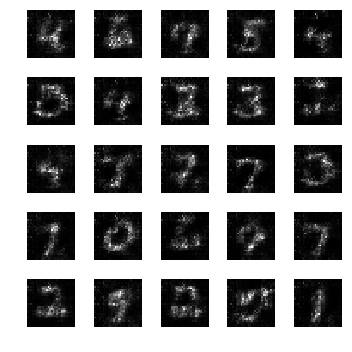

epoch: 171, time: 9.724450 | train_G_Loss: 0.405892, train_D_loss: 2.667403, train_acc: 0.822266
cv_G_Loss: 0.395215, cv_D_loss: 2.774661, cv_acc: 0.810300

epoch: 172, time: 9.643646 | train_G_Loss: 0.396560, train_D_loss: 2.652772, train_acc: 0.851562
cv_G_Loss: 0.273797, cv_D_loss: 2.822213, cv_acc: 0.818800
Model saved

epoch: 173, time: 9.579931 | train_G_Loss: 0.372048, train_D_loss: 2.596306, train_acc: 0.826172
cv_G_Loss: 0.275908, cv_D_loss: 2.829257, cv_acc: 0.812600

epoch: 174, time: 9.613279 | train_G_Loss: 0.361386, train_D_loss: 2.626884, train_acc: 0.814453
cv_G_Loss: 0.326350, cv_D_loss: 2.789133, cv_acc: 0.815400

epoch: 175, time: 9.697743 | train_G_Loss: 0.482884, train_D_loss: 2.598166, train_acc: 0.822266
cv_G_Loss: 0.560291, cv_D_loss: 2.904299, cv_acc: 0.811000

epoch: 176, time: 9.690635 | train_G_Loss: 0.544566, train_D_loss: 2.463191, train_acc: 0.828125
cv_G_Loss: 0.502309, cv_D_loss: 2.845698, cv_acc: 0.807100

epoch: 177, time: 9.595398 | train_G_Loss: 0.3

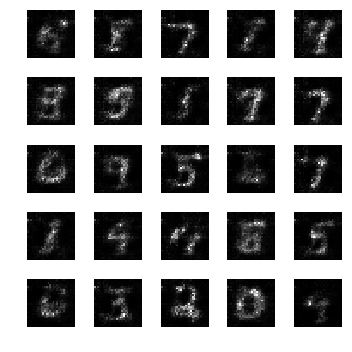

epoch: 181, time: 9.740616 | train_G_Loss: 0.396169, train_D_loss: 2.586182, train_acc: 0.894531
cv_G_Loss: 0.339541, cv_D_loss: 2.797293, cv_acc: 0.826600
Model saved

epoch: 182, time: 9.427567 | train_G_Loss: 0.287677, train_D_loss: 2.526042, train_acc: 0.931641
cv_G_Loss: 0.618878, cv_D_loss: 2.896559, cv_acc: 0.820600

epoch: 183, time: 9.670831 | train_G_Loss: 0.346060, train_D_loss: 2.467627, train_acc: 0.882812
cv_G_Loss: 0.223843, cv_D_loss: 2.928980, cv_acc: 0.814900

epoch: 184, time: 9.768981 | train_G_Loss: 0.341920, train_D_loss: 2.702192, train_acc: 0.855469
cv_G_Loss: 0.115706, cv_D_loss: 3.287186, cv_acc: 0.815400

epoch: 185, time: 9.734516 | train_G_Loss: 0.385607, train_D_loss: 2.500965, train_acc: 0.882812
cv_G_Loss: 0.597320, cv_D_loss: 2.910709, cv_acc: 0.827600
Model saved

epoch: 186, time: 9.680291 | train_G_Loss: 0.422079, train_D_loss: 2.221286, train_acc: 0.837891
cv_G_Loss: 0.316251, cv_D_loss: 2.820507, cv_acc: 0.816300

epoch: 187, time: 9.386785 | train

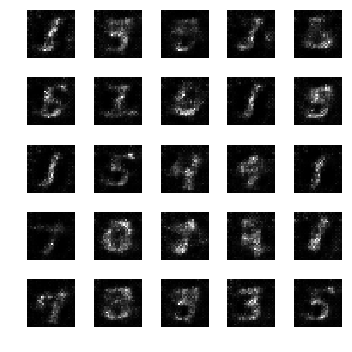

epoch: 191, time: 9.498325 | train_G_Loss: 0.417767, train_D_loss: 2.645102, train_acc: 0.876953
cv_G_Loss: 0.277488, cv_D_loss: 2.857542, cv_acc: 0.816200

epoch: 192, time: 9.608829 | train_G_Loss: 0.339151, train_D_loss: 2.623964, train_acc: 0.839844
cv_G_Loss: 0.184397, cv_D_loss: 2.989921, cv_acc: 0.822800

epoch: 193, time: 9.803687 | train_G_Loss: 0.424424, train_D_loss: 2.928280, train_acc: 0.796875
cv_G_Loss: 0.237174, cv_D_loss: 2.903749, cv_acc: 0.825000

epoch: 194, time: 9.683418 | train_G_Loss: 0.353545, train_D_loss: 3.028431, train_acc: 0.791016
cv_G_Loss: 0.141772, cv_D_loss: 3.151412, cv_acc: 0.823400

epoch: 195, time: 9.507746 | train_G_Loss: 0.346560, train_D_loss: 2.869333, train_acc: 0.800781
cv_G_Loss: 0.705793, cv_D_loss: 2.984245, cv_acc: 0.824900

epoch: 196, time: 9.685847 | train_G_Loss: 0.355189, train_D_loss: 2.740303, train_acc: 0.810547
cv_G_Loss: 0.158300, cv_D_loss: 3.147468, cv_acc: 0.809700

epoch: 197, time: 9.696538 | train_G_Loss: 0.452907, train

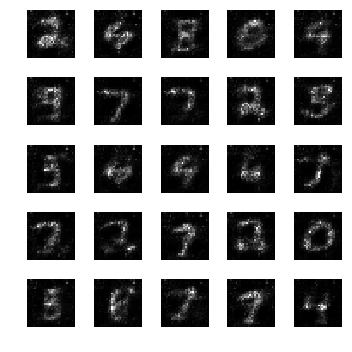

epoch: 201, time: 9.671781 | train_G_Loss: 0.340658, train_D_loss: 2.743133, train_acc: 0.820312
cv_G_Loss: 0.078546, cv_D_loss: 3.626598, cv_acc: 0.794200

epoch: 202, time: 9.594215 | train_G_Loss: 0.379922, train_D_loss: 2.716875, train_acc: 0.845703
cv_G_Loss: 0.861146, cv_D_loss: 3.332102, cv_acc: 0.818000

epoch: 203, time: 9.236499 | train_G_Loss: 0.398197, train_D_loss: 2.546600, train_acc: 0.857422
cv_G_Loss: 0.683701, cv_D_loss: 3.118469, cv_acc: 0.826000

epoch: 204, time: 9.680808 | train_G_Loss: 0.316305, train_D_loss: 2.846582, train_acc: 0.865234
cv_G_Loss: 0.079738, cv_D_loss: 3.614078, cv_acc: 0.812000

epoch: 205, time: 9.742212 | train_G_Loss: 0.438643, train_D_loss: 2.614906, train_acc: 0.861328
cv_G_Loss: 0.682531, cv_D_loss: 2.953532, cv_acc: 0.811000

epoch: 206, time: 9.737051 | train_G_Loss: 0.447246, train_D_loss: 2.663006, train_acc: 0.841797
cv_G_Loss: 0.587207, cv_D_loss: 2.877590, cv_acc: 0.834300
Model saved

epoch: 207, time: 9.557569 | train_G_Loss: 0.3

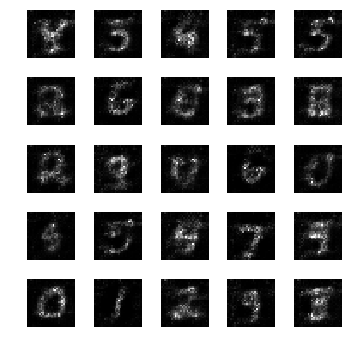

epoch: 211, time: 9.595377 | train_G_Loss: 0.281258, train_D_loss: 2.893884, train_acc: 0.800781
cv_G_Loss: 0.380694, cv_D_loss: 2.687971, cv_acc: 0.839300

epoch: 212, time: 9.465401 | train_G_Loss: 0.423917, train_D_loss: 2.814723, train_acc: 0.800781
cv_G_Loss: 0.413196, cv_D_loss: 2.745610, cv_acc: 0.822700

epoch: 213, time: 9.637280 | train_G_Loss: 0.393288, train_D_loss: 2.608694, train_acc: 0.775391
cv_G_Loss: 0.418224, cv_D_loss: 2.735365, cv_acc: 0.831000

epoch: 214, time: 9.568376 | train_G_Loss: 0.383941, train_D_loss: 2.825601, train_acc: 0.849609
cv_G_Loss: 0.601838, cv_D_loss: 2.785112, cv_acc: 0.830500

epoch: 215, time: 9.669485 | train_G_Loss: 0.546247, train_D_loss: 2.549647, train_acc: 0.857422
cv_G_Loss: 0.726505, cv_D_loss: 2.889348, cv_acc: 0.845400
Model saved

epoch: 216, time: 9.621588 | train_G_Loss: 0.378378, train_D_loss: 2.774734, train_acc: 0.808594
cv_G_Loss: 0.113363, cv_D_loss: 3.294949, cv_acc: 0.820700

epoch: 217, time: 9.428370 | train_G_Loss: 0.3

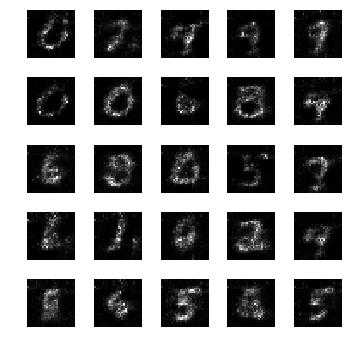

epoch: 221, time: 9.715835 | train_G_Loss: 0.508129, train_D_loss: 2.637367, train_acc: 0.855469
cv_G_Loss: 1.831221, cv_D_loss: 4.720185, cv_acc: 0.842000

epoch: 222, time: 9.642184 | train_G_Loss: 0.348341, train_D_loss: 2.641361, train_acc: 0.806641
cv_G_Loss: 0.147360, cv_D_loss: 3.099768, cv_acc: 0.820100

epoch: 223, time: 9.546376 | train_G_Loss: 0.347762, train_D_loss: 2.925326, train_acc: 0.802734
cv_G_Loss: 0.288954, cv_D_loss: 2.759679, cv_acc: 0.837200

epoch: 224, time: 9.326953 | train_G_Loss: 0.407063, train_D_loss: 2.573472, train_acc: 0.871094
cv_G_Loss: 0.254069, cv_D_loss: 2.792272, cv_acc: 0.841500

epoch: 225, time: 9.691844 | train_G_Loss: 0.392699, train_D_loss: 2.476354, train_acc: 0.853516
cv_G_Loss: 1.003849, cv_D_loss: 3.333620, cv_acc: 0.842800

epoch: 226, time: 9.674630 | train_G_Loss: 0.449421, train_D_loss: 2.718443, train_acc: 0.820312
cv_G_Loss: 0.643163, cv_D_loss: 2.818358, cv_acc: 0.845300

epoch: 227, time: 9.591496 | train_G_Loss: 0.275598, train

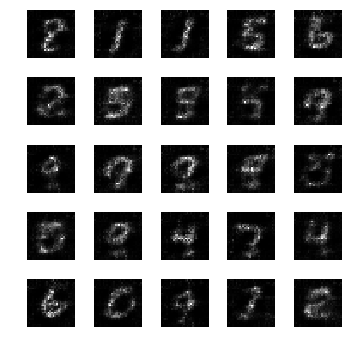

epoch: 231, time: 9.674101 | train_G_Loss: 0.445468, train_D_loss: 2.539367, train_acc: 0.873047
cv_G_Loss: 0.162813, cv_D_loss: 3.036710, cv_acc: 0.829500

epoch: 232, time: 9.681302 | train_G_Loss: 0.377321, train_D_loss: 2.839824, train_acc: 0.882812
cv_G_Loss: 3.069824, cv_D_loss: 7.131326, cv_acc: 0.820500

epoch: 233, time: 9.580511 | train_G_Loss: 0.321144, train_D_loss: 2.425890, train_acc: 0.855469
cv_G_Loss: 0.027718, cv_D_loss: 4.710823, cv_acc: 0.811600

epoch: 234, time: 9.742326 | train_G_Loss: 0.307330, train_D_loss: 2.769135, train_acc: 0.826172
cv_G_Loss: 0.315740, cv_D_loss: 2.744912, cv_acc: 0.838200

epoch: 235, time: 9.617724 | train_G_Loss: 0.475235, train_D_loss: 2.552807, train_acc: 0.843750
cv_G_Loss: 0.855329, cv_D_loss: 3.102357, cv_acc: 0.840500

epoch: 236, time: 9.495890 | train_G_Loss: 0.439709, train_D_loss: 2.569526, train_acc: 0.851562
cv_G_Loss: 2.856632, cv_D_loss: 6.799594, cv_acc: 0.783400

epoch: 237, time: 9.449446 | train_G_Loss: 0.352695, train

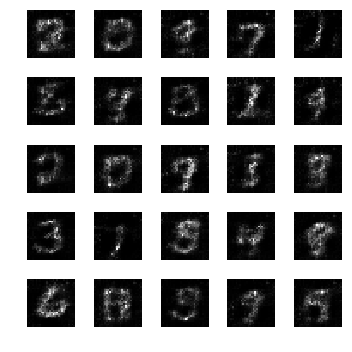

epoch: 241, time: 9.568514 | train_G_Loss: 0.321267, train_D_loss: 2.607525, train_acc: 0.875000
cv_G_Loss: 0.053811, cv_D_loss: 3.822358, cv_acc: 0.832400

epoch: 242, time: 9.623570 | train_G_Loss: 0.334735, train_D_loss: 2.847214, train_acc: 0.871094
cv_G_Loss: 0.529143, cv_D_loss: 2.649182, cv_acc: 0.852000
Model saved

epoch: 243, time: 9.607341 | train_G_Loss: 0.447307, train_D_loss: 2.603780, train_acc: 0.851562
cv_G_Loss: 0.430232, cv_D_loss: 2.699183, cv_acc: 0.844200

epoch: 244, time: 9.719363 | train_G_Loss: 0.423040, train_D_loss: 2.557754, train_acc: 0.822266
cv_G_Loss: 0.312805, cv_D_loss: 2.704798, cv_acc: 0.840800

epoch: 245, time: 9.669614 | train_G_Loss: 0.421408, train_D_loss: 2.582113, train_acc: 0.814453
cv_G_Loss: 1.303163, cv_D_loss: 3.661201, cv_acc: 0.847100

epoch: 246, time: 9.372356 | train_G_Loss: 0.447225, train_D_loss: 2.918795, train_acc: 0.835938
cv_G_Loss: 0.737520, cv_D_loss: 2.878113, cv_acc: 0.852700
Model saved

epoch: 247, time: 9.691822 | train

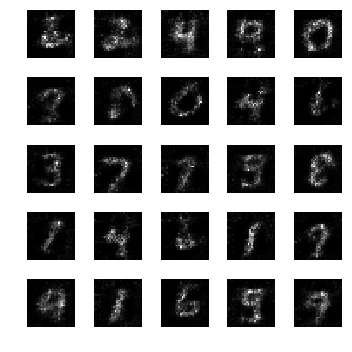

epoch: 251, time: 9.503851 | train_G_Loss: 0.331107, train_D_loss: 2.615556, train_acc: 0.830078
cv_G_Loss: 0.505731, cv_D_loss: 2.817001, cv_acc: 0.838200

epoch: 252, time: 9.391378 | train_G_Loss: 0.341070, train_D_loss: 2.703427, train_acc: 0.830078
cv_G_Loss: 0.557431, cv_D_loss: 2.683084, cv_acc: 0.851100

epoch: 253, time: 9.592862 | train_G_Loss: 0.488011, train_D_loss: 2.688853, train_acc: 0.841797
cv_G_Loss: 0.239418, cv_D_loss: 2.787692, cv_acc: 0.844600

epoch: 254, time: 9.596609 | train_G_Loss: 0.444168, train_D_loss: 2.803112, train_acc: 0.845703
cv_G_Loss: 1.072742, cv_D_loss: 3.363641, cv_acc: 0.848600

epoch: 255, time: 9.629278 | train_G_Loss: 0.356124, train_D_loss: 2.699706, train_acc: 0.873047
cv_G_Loss: 0.177252, cv_D_loss: 2.942992, cv_acc: 0.837100

epoch: 256, time: 9.708139 | train_G_Loss: 0.310292, train_D_loss: 2.598002, train_acc: 0.861328
cv_G_Loss: 0.178015, cv_D_loss: 2.903736, cv_acc: 0.844600

epoch: 257, time: 9.452225 | train_G_Loss: 0.490804, train

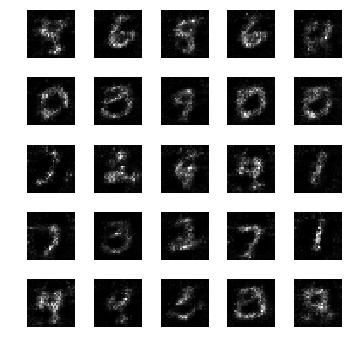

epoch: 261, time: 9.713380 | train_G_Loss: 0.430692, train_D_loss: 2.618217, train_acc: 0.828125
cv_G_Loss: 0.360191, cv_D_loss: 2.756672, cv_acc: 0.833500

epoch: 262, time: 9.625836 | train_G_Loss: 0.453535, train_D_loss: 2.634724, train_acc: 0.867188
cv_G_Loss: 0.084009, cv_D_loss: 3.512918, cv_acc: 0.825900

epoch: 263, time: 9.702059 | train_G_Loss: 0.377877, train_D_loss: 2.624465, train_acc: 0.878906
cv_G_Loss: 1.526640, cv_D_loss: 4.324832, cv_acc: 0.826000

epoch: 264, time: 9.471220 | train_G_Loss: 0.383343, train_D_loss: 2.528315, train_acc: 0.886719
cv_G_Loss: 0.839265, cv_D_loss: 3.026549, cv_acc: 0.856800
Model saved

epoch: 265, time: 9.613865 | train_G_Loss: 0.450184, train_D_loss: 2.531255, train_acc: 0.853516
cv_G_Loss: 0.990434, cv_D_loss: 2.998150, cv_acc: 0.844100

epoch: 266, time: 9.575062 | train_G_Loss: 0.422330, train_D_loss: 2.597296, train_acc: 0.839844
cv_G_Loss: 0.078401, cv_D_loss: 3.519186, cv_acc: 0.832100

epoch: 267, time: 9.570200 | train_G_Loss: 0.3

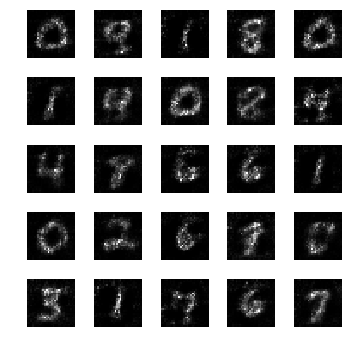

epoch: 271, time: 9.519669 | train_G_Loss: 0.255168, train_D_loss: 2.796402, train_acc: 0.802734
cv_G_Loss: 0.229786, cv_D_loss: 2.786745, cv_acc: 0.844300

epoch: 272, time: 9.523979 | train_G_Loss: 0.383571, train_D_loss: 2.652817, train_acc: 0.818359
cv_G_Loss: 0.120651, cv_D_loss: 3.142414, cv_acc: 0.848100

epoch: 273, time: 9.031766 | train_G_Loss: 0.434191, train_D_loss: 2.824948, train_acc: 0.810547
cv_G_Loss: 0.777673, cv_D_loss: 2.865549, cv_acc: 0.853400

epoch: 274, time: 8.971308 | train_G_Loss: 0.379819, train_D_loss: 2.689425, train_acc: 0.816406
cv_G_Loss: 0.087127, cv_D_loss: 3.413343, cv_acc: 0.845000

epoch: 275, time: 9.581305 | train_G_Loss: 0.312916, train_D_loss: 2.789849, train_acc: 0.810547
cv_G_Loss: 1.269443, cv_D_loss: 3.739568, cv_acc: 0.841200

epoch: 276, time: 9.564054 | train_G_Loss: 0.447089, train_D_loss: 2.582020, train_acc: 0.843750
cv_G_Loss: 0.065175, cv_D_loss: 3.632388, cv_acc: 0.841200

epoch: 277, time: 9.410571 | train_G_Loss: 0.431318, train

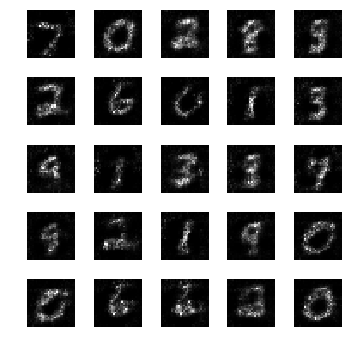

epoch: 281, time: 9.751625 | train_G_Loss: 0.277848, train_D_loss: 2.675916, train_acc: 0.814453
cv_G_Loss: 0.215791, cv_D_loss: 2.780623, cv_acc: 0.849700

epoch: 282, time: 9.558761 | train_G_Loss: 0.419129, train_D_loss: 2.554581, train_acc: 0.861328
cv_G_Loss: 1.398989, cv_D_loss: 3.765212, cv_acc: 0.855200

epoch: 283, time: 9.564240 | train_G_Loss: 0.383285, train_D_loss: 2.628220, train_acc: 0.892578
cv_G_Loss: 0.265110, cv_D_loss: 2.763667, cv_acc: 0.848000

epoch: 284, time: 9.559080 | train_G_Loss: 0.428869, train_D_loss: 2.280330, train_acc: 0.890625
cv_G_Loss: 1.007832, cv_D_loss: 3.202436, cv_acc: 0.838300

epoch: 285, time: 9.568606 | train_G_Loss: 0.396073, train_D_loss: 2.418989, train_acc: 0.882812
cv_G_Loss: 0.389886, cv_D_loss: 2.607499, cv_acc: 0.858800

epoch: 286, time: 9.351244 | train_G_Loss: 0.359347, train_D_loss: 2.615711, train_acc: 0.828125
cv_G_Loss: 0.520923, cv_D_loss: 2.820933, cv_acc: 0.826000

epoch: 287, time: 9.707927 | train_G_Loss: 0.337587, train

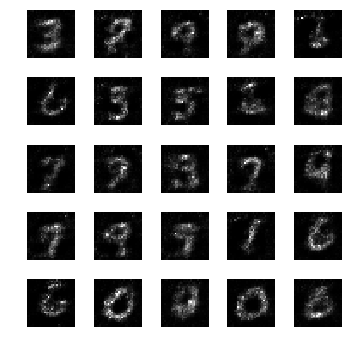

epoch: 291, time: 9.231097 | train_G_Loss: 0.349489, train_D_loss: 2.707312, train_acc: 0.843750
cv_G_Loss: 0.320144, cv_D_loss: 2.684134, cv_acc: 0.846400

epoch: 292, time: 9.385372 | train_G_Loss: 0.328353, train_D_loss: 2.499372, train_acc: 0.880859
cv_G_Loss: 0.153810, cv_D_loss: 2.949779, cv_acc: 0.849300

epoch: 293, time: 9.500523 | train_G_Loss: 0.454978, train_D_loss: 2.562318, train_acc: 0.900391
cv_G_Loss: 0.478329, cv_D_loss: 2.637055, cv_acc: 0.856700

epoch: 294, time: 9.503520 | train_G_Loss: 0.402985, train_D_loss: 2.647908, train_acc: 0.857422
cv_G_Loss: 0.060972, cv_D_loss: 3.725468, cv_acc: 0.834200

epoch: 295, time: 9.370893 | train_G_Loss: 0.348190, train_D_loss: 2.639197, train_acc: 0.808594
cv_G_Loss: 0.596737, cv_D_loss: 2.596115, cv_acc: 0.860100

epoch: 296, time: 9.579685 | train_G_Loss: 0.333814, train_D_loss: 2.961985, train_acc: 0.820312
cv_G_Loss: 0.382757, cv_D_loss: 2.689357, cv_acc: 0.845900

epoch: 297, time: 9.381074 | train_G_Loss: 0.355581, train

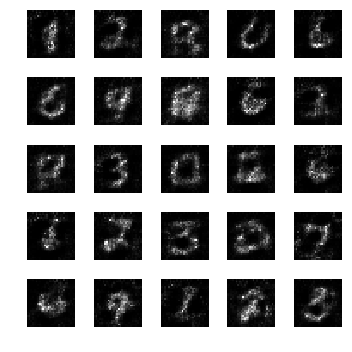

epoch: 301, time: 9.579247 | train_G_Loss: 0.433240, train_D_loss: 2.507519, train_acc: 0.851562
cv_G_Loss: 0.497867, cv_D_loss: 2.721905, cv_acc: 0.852300

epoch: 302, time: 9.505139 | train_G_Loss: 0.416762, train_D_loss: 2.452566, train_acc: 0.830078
cv_G_Loss: 1.163624, cv_D_loss: 3.611466, cv_acc: 0.815600

epoch: 303, time: 9.389979 | train_G_Loss: 0.350762, train_D_loss: 2.720144, train_acc: 0.835938
cv_G_Loss: 0.685529, cv_D_loss: 2.841680, cv_acc: 0.852400

epoch: 304, time: 9.153550 | train_G_Loss: 0.371741, train_D_loss: 2.847052, train_acc: 0.822266
cv_G_Loss: 0.488708, cv_D_loss: 2.676387, cv_acc: 0.857300

epoch: 305, time: 9.372720 | train_G_Loss: 0.465286, train_D_loss: 2.631301, train_acc: 0.869141
cv_G_Loss: 0.433616, cv_D_loss: 2.678062, cv_acc: 0.854800

epoch: 306, time: 9.352591 | train_G_Loss: 0.392012, train_D_loss: 2.673236, train_acc: 0.871094
cv_G_Loss: 0.472745, cv_D_loss: 2.559117, cv_acc: 0.863500

epoch: 307, time: 9.420156 | train_G_Loss: 0.382750, train

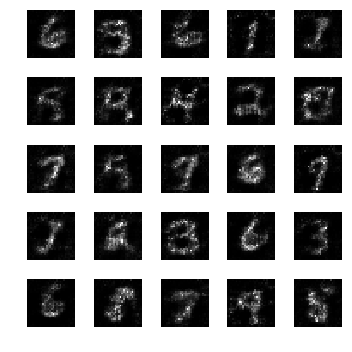

epoch: 311, time: 9.508824 | train_G_Loss: 0.490594, train_D_loss: 2.536257, train_acc: 0.816406
cv_G_Loss: 0.548059, cv_D_loss: 2.779905, cv_acc: 0.836100

epoch: 312, time: 9.579893 | train_G_Loss: 0.438575, train_D_loss: 2.794488, train_acc: 0.822266
cv_G_Loss: 0.511523, cv_D_loss: 2.661026, cv_acc: 0.851800

epoch: 313, time: 9.561945 | train_G_Loss: 0.462137, train_D_loss: 2.773075, train_acc: 0.857422
cv_G_Loss: 1.035492, cv_D_loss: 3.290510, cv_acc: 0.854100

epoch: 314, time: 9.462005 | train_G_Loss: 0.409363, train_D_loss: 2.442486, train_acc: 0.839844
cv_G_Loss: 0.933619, cv_D_loss: 3.143711, cv_acc: 0.864400

epoch: 315, time: 9.501108 | train_G_Loss: 0.340429, train_D_loss: 2.902677, train_acc: 0.867188
cv_G_Loss: 1.015107, cv_D_loss: 3.239180, cv_acc: 0.848400

epoch: 316, time: 9.442952 | train_G_Loss: 0.443532, train_D_loss: 2.403996, train_acc: 0.900391
cv_G_Loss: 0.277025, cv_D_loss: 2.761594, cv_acc: 0.845200

epoch: 317, time: 9.285669 | train_G_Loss: 0.372171, train

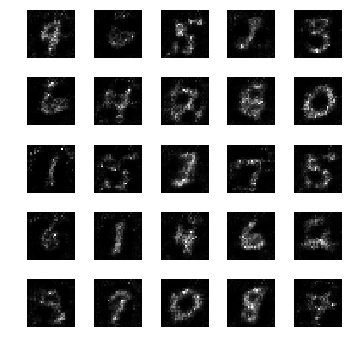

epoch: 321, time: 9.605649 | train_G_Loss: 0.389544, train_D_loss: 2.647139, train_acc: 0.839844
cv_G_Loss: 0.236985, cv_D_loss: 2.728498, cv_acc: 0.853800

epoch: 322, time: 9.533946 | train_G_Loss: 0.384543, train_D_loss: 2.793016, train_acc: 0.849609
cv_G_Loss: 0.269266, cv_D_loss: 2.652961, cv_acc: 0.863600

epoch: 323, time: 9.194917 | train_G_Loss: 0.210966, train_D_loss: 2.830126, train_acc: 0.820312
cv_G_Loss: 0.268734, cv_D_loss: 2.631792, cv_acc: 0.862900

epoch: 324, time: 9.537666 | train_G_Loss: 0.325612, train_D_loss: 2.592940, train_acc: 0.857422
cv_G_Loss: 0.332740, cv_D_loss: 2.594874, cv_acc: 0.868000
Model saved

epoch: 325, time: 9.489479 | train_G_Loss: 0.338702, train_D_loss: 2.709549, train_acc: 0.851562
cv_G_Loss: 0.349372, cv_D_loss: 2.646365, cv_acc: 0.858700

epoch: 326, time: 9.407698 | train_G_Loss: 0.389963, train_D_loss: 2.782280, train_acc: 0.855469
cv_G_Loss: 1.281921, cv_D_loss: 3.605004, cv_acc: 0.863200

epoch: 327, time: 9.573073 | train_G_Loss: 0.3

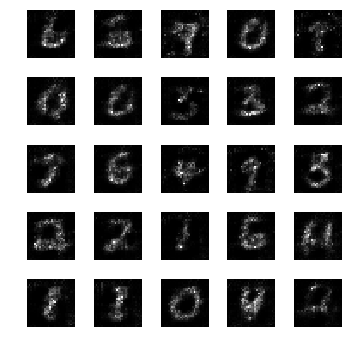

epoch: 331, time: 9.467532 | train_G_Loss: 0.380094, train_D_loss: 2.455578, train_acc: 0.884766
cv_G_Loss: 0.369031, cv_D_loss: 2.641292, cv_acc: 0.859400

epoch: 332, time: 9.577827 | train_G_Loss: 0.439164, train_D_loss: 2.581759, train_acc: 0.882812
cv_G_Loss: 0.223308, cv_D_loss: 2.784116, cv_acc: 0.859600

epoch: 333, time: 9.542700 | train_G_Loss: 0.457190, train_D_loss: 2.764806, train_acc: 0.886719
cv_G_Loss: 0.275634, cv_D_loss: 2.767413, cv_acc: 0.851700

epoch: 334, time: 9.421456 | train_G_Loss: 0.285040, train_D_loss: 2.630075, train_acc: 0.855469
cv_G_Loss: 0.265403, cv_D_loss: 2.687545, cv_acc: 0.863600

epoch: 335, time: 9.460685 | train_G_Loss: 0.276702, train_D_loss: 2.888842, train_acc: 0.837891
cv_G_Loss: 0.154257, cv_D_loss: 2.935191, cv_acc: 0.857600

epoch: 336, time: 9.471560 | train_G_Loss: 0.362467, train_D_loss: 2.500761, train_acc: 0.839844
cv_G_Loss: 0.444796, cv_D_loss: 2.637250, cv_acc: 0.869200
Model saved

epoch: 337, time: 9.529280 | train_G_Loss: 0.6

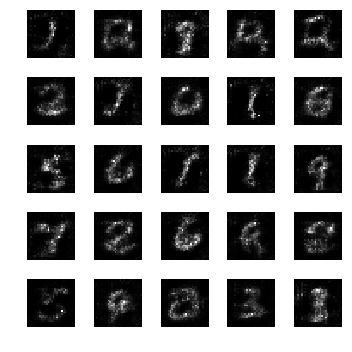

epoch: 341, time: 9.509716 | train_G_Loss: 0.386710, train_D_loss: 2.641424, train_acc: 0.869141
cv_G_Loss: 0.634369, cv_D_loss: 2.786645, cv_acc: 0.868000

epoch: 342, time: 9.420663 | train_G_Loss: 0.308719, train_D_loss: 2.524146, train_acc: 0.869141
cv_G_Loss: 0.116849, cv_D_loss: 3.115820, cv_acc: 0.862900

epoch: 343, time: 9.387433 | train_G_Loss: 0.593307, train_D_loss: 2.672201, train_acc: 0.894531
cv_G_Loss: 1.601675, cv_D_loss: 4.254975, cv_acc: 0.870200
Model saved

epoch: 344, time: 9.572598 | train_G_Loss: 0.385519, train_D_loss: 2.452116, train_acc: 0.880859
cv_G_Loss: 0.450913, cv_D_loss: 2.655063, cv_acc: 0.865200

epoch: 345, time: 9.565670 | train_G_Loss: 0.245379, train_D_loss: 2.563916, train_acc: 0.835938
cv_G_Loss: 0.072808, cv_D_loss: 3.477948, cv_acc: 0.859900

epoch: 346, time: 9.616065 | train_G_Loss: 0.321781, train_D_loss: 2.772842, train_acc: 0.878906
cv_G_Loss: 0.560754, cv_D_loss: 2.717060, cv_acc: 0.868100

epoch: 347, time: 9.536521 | train_G_Loss: 0.3

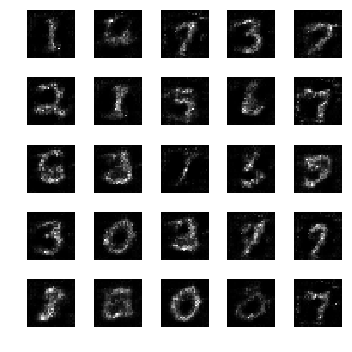

epoch: 351, time: 9.302420 | train_G_Loss: 0.288748, train_D_loss: 2.561745, train_acc: 0.865234
cv_G_Loss: 0.321761, cv_D_loss: 2.606817, cv_acc: 0.872100

epoch: 352, time: 9.501966 | train_G_Loss: 0.425856, train_D_loss: 2.769855, train_acc: 0.886719
cv_G_Loss: 0.370128, cv_D_loss: 2.660874, cv_acc: 0.854100

epoch: 353, time: 9.507010 | train_G_Loss: 0.380496, train_D_loss: 2.484617, train_acc: 0.890625
cv_G_Loss: 0.253935, cv_D_loss: 2.693398, cv_acc: 0.873900
Model saved

epoch: 354, time: 9.370062 | train_G_Loss: 0.416127, train_D_loss: 2.549286, train_acc: 0.857422
cv_G_Loss: 0.230588, cv_D_loss: 2.733506, cv_acc: 0.870100

epoch: 355, time: 9.237684 | train_G_Loss: 0.359704, train_D_loss: 2.932348, train_acc: 0.857422
cv_G_Loss: 0.206175, cv_D_loss: 2.829783, cv_acc: 0.867300

epoch: 356, time: 9.487898 | train_G_Loss: 0.356377, train_D_loss: 2.637882, train_acc: 0.886719
cv_G_Loss: 0.252376, cv_D_loss: 2.690886, cv_acc: 0.869600

epoch: 357, time: 9.500752 | train_G_Loss: 0.3

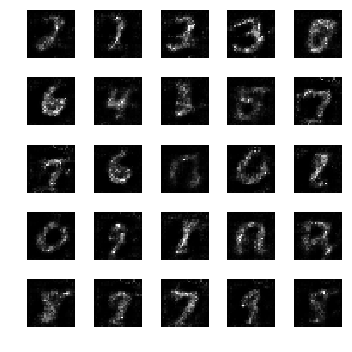

epoch: 361, time: 9.349324 | train_G_Loss: 0.550059, train_D_loss: 2.823027, train_acc: 0.886719
cv_G_Loss: 0.450090, cv_D_loss: 2.691315, cv_acc: 0.867300

epoch: 362, time: 9.373638 | train_G_Loss: 0.430701, train_D_loss: 2.386215, train_acc: 0.890625
cv_G_Loss: 0.737566, cv_D_loss: 2.943245, cv_acc: 0.870200

epoch: 363, time: 9.462079 | train_G_Loss: 0.339048, train_D_loss: 2.663592, train_acc: 0.849609
cv_G_Loss: 0.255354, cv_D_loss: 2.681904, cv_acc: 0.873000

epoch: 364, time: 9.396247 | train_G_Loss: 0.494906, train_D_loss: 2.569745, train_acc: 0.871094
cv_G_Loss: 0.535561, cv_D_loss: 2.734763, cv_acc: 0.870800

epoch: 365, time: 9.407284 | train_G_Loss: 0.407188, train_D_loss: 2.488114, train_acc: 0.912109
cv_G_Loss: 0.172332, cv_D_loss: 2.866179, cv_acc: 0.863500

epoch: 366, time: 9.352531 | train_G_Loss: 0.469155, train_D_loss: 2.424903, train_acc: 0.917969
cv_G_Loss: 0.727228, cv_D_loss: 2.900417, cv_acc: 0.873600

epoch: 367, time: 9.522832 | train_G_Loss: 0.493086, train

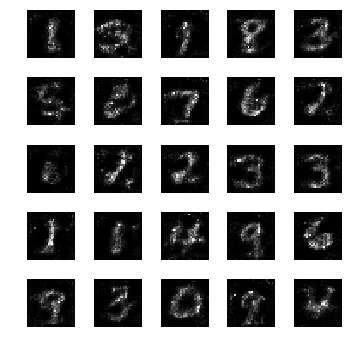

epoch: 371, time: 9.700954 | train_G_Loss: 0.474040, train_D_loss: 2.405890, train_acc: 0.914062
cv_G_Loss: 0.343841, cv_D_loss: 2.661542, cv_acc: 0.871100

epoch: 372, time: 9.515813 | train_G_Loss: 0.429748, train_D_loss: 2.655830, train_acc: 0.873047
cv_G_Loss: 0.260079, cv_D_loss: 2.691679, cv_acc: 0.870000

epoch: 373, time: 9.447198 | train_G_Loss: 0.320432, train_D_loss: 2.446643, train_acc: 0.900391
cv_G_Loss: 0.125294, cv_D_loss: 3.049035, cv_acc: 0.872400

epoch: 374, time: 9.553479 | train_G_Loss: 0.342101, train_D_loss: 2.471239, train_acc: 0.886719
cv_G_Loss: 0.331491, cv_D_loss: 2.657077, cv_acc: 0.871800

epoch: 375, time: 9.259897 | train_G_Loss: 0.480504, train_D_loss: 2.676949, train_acc: 0.888672
cv_G_Loss: 0.476232, cv_D_loss: 2.706682, cv_acc: 0.871800

epoch: 376, time: 9.468347 | train_G_Loss: 0.384785, train_D_loss: 2.555131, train_acc: 0.888672
cv_G_Loss: 0.669632, cv_D_loss: 2.798252, cv_acc: 0.874200
Model saved

epoch: 377, time: 9.365751 | train_G_Loss: 0.3

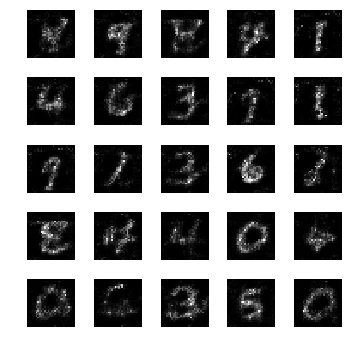

epoch: 381, time: 9.315119 | train_G_Loss: 0.323865, train_D_loss: 2.488800, train_acc: 0.857422
cv_G_Loss: 0.171646, cv_D_loss: 2.856209, cv_acc: 0.862200

epoch: 382, time: 9.320209 | train_G_Loss: 0.522172, train_D_loss: 2.753845, train_acc: 0.857422
cv_G_Loss: 0.520863, cv_D_loss: 2.813334, cv_acc: 0.857300

epoch: 383, time: 9.566598 | train_G_Loss: 0.514075, train_D_loss: 2.673152, train_acc: 0.867188
cv_G_Loss: 0.781955, cv_D_loss: 2.951044, cv_acc: 0.872900

epoch: 384, time: 9.455463 | train_G_Loss: 0.391637, train_D_loss: 2.853330, train_acc: 0.828125
cv_G_Loss: 0.959156, cv_D_loss: 3.175287, cv_acc: 0.867700

epoch: 385, time: 9.499579 | train_G_Loss: 0.257758, train_D_loss: 2.828595, train_acc: 0.857422
cv_G_Loss: 0.186467, cv_D_loss: 2.798774, cv_acc: 0.870600

epoch: 386, time: 9.473588 | train_G_Loss: 0.363081, train_D_loss: 2.424936, train_acc: 0.882812
cv_G_Loss: 0.513629, cv_D_loss: 2.626332, cv_acc: 0.875900

epoch: 387, time: 9.409958 | train_G_Loss: 0.387341, train

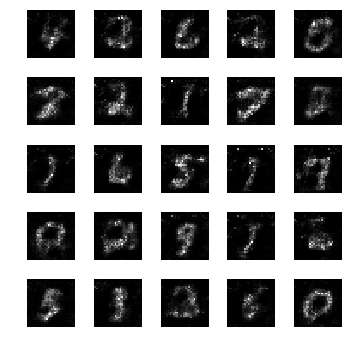

epoch: 391, time: 9.559384 | train_G_Loss: 0.488094, train_D_loss: 2.357320, train_acc: 0.904297
cv_G_Loss: 1.347716, cv_D_loss: 3.971594, cv_acc: 0.842700

epoch: 392, time: 9.549973 | train_G_Loss: 0.503935, train_D_loss: 2.545055, train_acc: 0.900391
cv_G_Loss: 0.667679, cv_D_loss: 2.827966, cv_acc: 0.873000

epoch: 393, time: 9.539705 | train_G_Loss: 0.377470, train_D_loss: 2.528745, train_acc: 0.865234
cv_G_Loss: 0.348279, cv_D_loss: 2.628403, cv_acc: 0.863800

epoch: 394, time: 9.397519 | train_G_Loss: 0.446053, train_D_loss: 2.425894, train_acc: 0.843750
cv_G_Loss: 0.086433, cv_D_loss: 3.318337, cv_acc: 0.871500

epoch: 395, time: 9.235329 | train_G_Loss: 0.298509, train_D_loss: 2.873561, train_acc: 0.876953
cv_G_Loss: 0.143643, cv_D_loss: 2.942768, cv_acc: 0.871000

epoch: 396, time: 9.620491 | train_G_Loss: 0.366497, train_D_loss: 2.454440, train_acc: 0.861328
cv_G_Loss: 0.623170, cv_D_loss: 2.810608, cv_acc: 0.864500

epoch: 397, time: 9.487643 | train_G_Loss: 0.359848, train

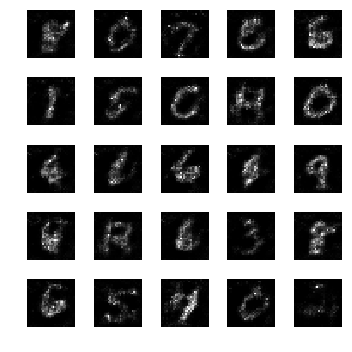

epoch: 401, time: 9.330220 | train_G_Loss: 0.317573, train_D_loss: 2.513138, train_acc: 0.863281
cv_G_Loss: 0.372221, cv_D_loss: 2.580752, cv_acc: 0.879900
Model saved

epoch: 402, time: 9.527853 | train_G_Loss: 0.270330, train_D_loss: 2.505471, train_acc: 0.859375
cv_G_Loss: 0.134691, cv_D_loss: 2.963835, cv_acc: 0.874500

epoch: 403, time: 9.517721 | train_G_Loss: 0.396742, train_D_loss: 2.618707, train_acc: 0.859375
cv_G_Loss: 0.627456, cv_D_loss: 2.727358, cv_acc: 0.877700

epoch: 404, time: 9.333947 | train_G_Loss: 0.351489, train_D_loss: 2.852712, train_acc: 0.814453
cv_G_Loss: 0.598763, cv_D_loss: 2.677859, cv_acc: 0.880700
Model saved

epoch: 405, time: 9.486169 | train_G_Loss: 0.310516, train_D_loss: 2.982148, train_acc: 0.839844
cv_G_Loss: 0.568404, cv_D_loss: 2.655869, cv_acc: 0.878800

epoch: 406, time: 9.466456 | train_G_Loss: 0.480803, train_D_loss: 2.496885, train_acc: 0.878906
cv_G_Loss: 0.495570, cv_D_loss: 2.619088, cv_acc: 0.883300
Model saved

epoch: 407, time: 9.52

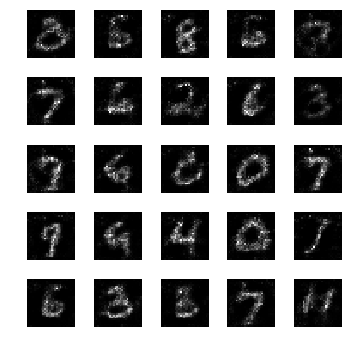

epoch: 411, time: 9.495990 | train_G_Loss: 0.430015, train_D_loss: 2.593410, train_acc: 0.878906
cv_G_Loss: 0.446347, cv_D_loss: 2.575453, cv_acc: 0.876500

epoch: 412, time: 9.605555 | train_G_Loss: 0.395675, train_D_loss: 2.772341, train_acc: 0.835938
cv_G_Loss: 0.573512, cv_D_loss: 2.640803, cv_acc: 0.879300

epoch: 413, time: 9.454559 | train_G_Loss: 0.316404, train_D_loss: 2.713534, train_acc: 0.853516
cv_G_Loss: 0.145045, cv_D_loss: 2.893351, cv_acc: 0.880200

epoch: 414, time: 9.307366 | train_G_Loss: 0.385915, train_D_loss: 2.570275, train_acc: 0.859375
cv_G_Loss: 0.325251, cv_D_loss: 2.572840, cv_acc: 0.877200

epoch: 415, time: 9.606996 | train_G_Loss: 0.347846, train_D_loss: 2.644688, train_acc: 0.888672
cv_G_Loss: 0.134188, cv_D_loss: 2.986036, cv_acc: 0.873500

epoch: 416, time: 9.714890 | train_G_Loss: 0.501518, train_D_loss: 2.459095, train_acc: 0.921875
cv_G_Loss: 0.337333, cv_D_loss: 2.579494, cv_acc: 0.872900

epoch: 417, time: 9.544972 | train_G_Loss: 0.297162, train

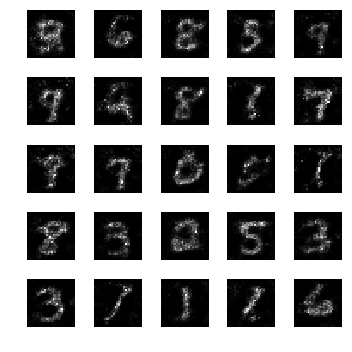

epoch: 421, time: 9.380149 | train_G_Loss: 0.353267, train_D_loss: 2.448351, train_acc: 0.884766
cv_G_Loss: 0.330740, cv_D_loss: 2.575323, cv_acc: 0.874100

epoch: 422, time: 9.471565 | train_G_Loss: 0.424839, train_D_loss: 2.351582, train_acc: 0.873047
cv_G_Loss: 0.560445, cv_D_loss: 2.644474, cv_acc: 0.882200

epoch: 423, time: 9.508385 | train_G_Loss: 0.323276, train_D_loss: 2.763302, train_acc: 0.869141
cv_G_Loss: 0.451316, cv_D_loss: 2.606996, cv_acc: 0.879500

epoch: 424, time: 9.495207 | train_G_Loss: 0.292835, train_D_loss: 2.568697, train_acc: 0.890625
cv_G_Loss: 0.341816, cv_D_loss: 2.564776, cv_acc: 0.880200

epoch: 425, time: 9.436797 | train_G_Loss: 0.356781, train_D_loss: 2.423231, train_acc: 0.849609
cv_G_Loss: 0.580830, cv_D_loss: 2.654124, cv_acc: 0.883200

epoch: 426, time: 9.422598 | train_G_Loss: 0.352449, train_D_loss: 2.669650, train_acc: 0.880859
cv_G_Loss: 1.004633, cv_D_loss: 3.162934, cv_acc: 0.877500

epoch: 427, time: 9.362553 | train_G_Loss: 0.318731, train

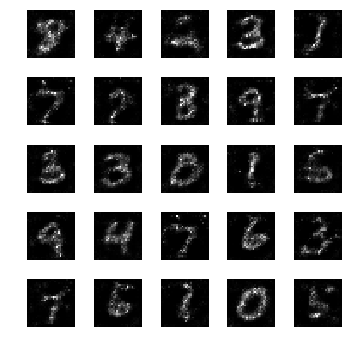

epoch: 431, time: 9.610089 | train_G_Loss: 0.288733, train_D_loss: 2.474358, train_acc: 0.861328
cv_G_Loss: 0.191462, cv_D_loss: 2.734026, cv_acc: 0.883000

epoch: 432, time: 9.457479 | train_G_Loss: 0.351383, train_D_loss: 2.631994, train_acc: 0.884766
cv_G_Loss: 0.438237, cv_D_loss: 2.550297, cv_acc: 0.881500

epoch: 433, time: 9.477920 | train_G_Loss: 0.437892, train_D_loss: 2.366990, train_acc: 0.878906
cv_G_Loss: 0.338237, cv_D_loss: 2.588382, cv_acc: 0.875300

epoch: 434, time: 9.455825 | train_G_Loss: 0.513750, train_D_loss: 2.421174, train_acc: 0.886719
cv_G_Loss: 1.505241, cv_D_loss: 3.988352, cv_acc: 0.879600

epoch: 435, time: 9.467599 | train_G_Loss: 0.476398, train_D_loss: 2.576075, train_acc: 0.875000
cv_G_Loss: 0.453468, cv_D_loss: 2.659492, cv_acc: 0.857200

epoch: 436, time: 9.541893 | train_G_Loss: 0.225193, train_D_loss: 2.760036, train_acc: 0.863281
cv_G_Loss: 0.108450, cv_D_loss: 3.082292, cv_acc: 0.876800

epoch: 437, time: 9.487784 | train_G_Loss: 0.358796, train

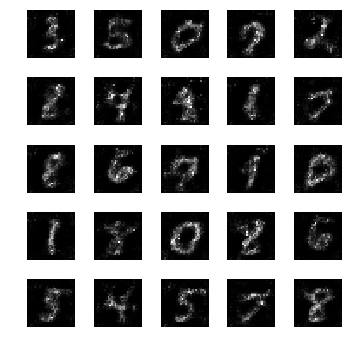

epoch: 441, time: 9.589931 | train_G_Loss: 0.336002, train_D_loss: 2.483196, train_acc: 0.902344
cv_G_Loss: 0.407398, cv_D_loss: 2.548054, cv_acc: 0.886000
Model saved

epoch: 442, time: 9.002027 | train_G_Loss: 0.365010, train_D_loss: 2.512028, train_acc: 0.894531
cv_G_Loss: 0.395264, cv_D_loss: 2.535129, cv_acc: 0.886100
Model saved

epoch: 443, time: 9.558663 | train_G_Loss: 0.304135, train_D_loss: 2.589294, train_acc: 0.904297
cv_G_Loss: 0.203725, cv_D_loss: 2.805385, cv_acc: 0.846700

epoch: 444, time: 9.529753 | train_G_Loss: 0.449970, train_D_loss: 2.468254, train_acc: 0.865234
cv_G_Loss: 0.320451, cv_D_loss: 2.534876, cv_acc: 0.881600

epoch: 445, time: 9.386314 | train_G_Loss: 0.383770, train_D_loss: 2.713189, train_acc: 0.859375
cv_G_Loss: 0.450832, cv_D_loss: 2.546306, cv_acc: 0.883100

epoch: 446, time: 9.128031 | train_G_Loss: 0.372176, train_D_loss: 2.498055, train_acc: 0.878906
cv_G_Loss: 0.806280, cv_D_loss: 2.888330, cv_acc: 0.883700

epoch: 447, time: 9.430537 | train

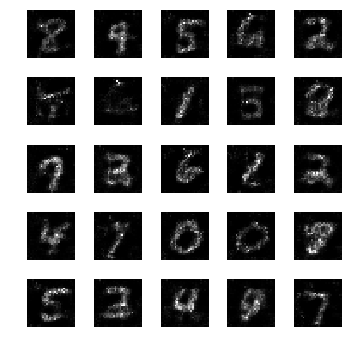

epoch: 451, time: 9.673286 | train_G_Loss: 0.348046, train_D_loss: 2.449960, train_acc: 0.882812
cv_G_Loss: 0.339766, cv_D_loss: 2.594591, cv_acc: 0.879000

epoch: 452, time: 9.542012 | train_G_Loss: 0.391870, train_D_loss: 2.567997, train_acc: 0.896484
cv_G_Loss: 0.508833, cv_D_loss: 2.587994, cv_acc: 0.884000

epoch: 453, time: 9.255272 | train_G_Loss: 0.363994, train_D_loss: 2.522889, train_acc: 0.859375
cv_G_Loss: 0.268289, cv_D_loss: 2.616800, cv_acc: 0.880300

epoch: 454, time: 9.521131 | train_G_Loss: 0.314102, train_D_loss: 2.729855, train_acc: 0.880859
cv_G_Loss: 0.287086, cv_D_loss: 2.576614, cv_acc: 0.888700
Model saved

epoch: 455, time: 9.454776 | train_G_Loss: 0.345669, train_D_loss: 2.503616, train_acc: 0.849609
cv_G_Loss: 0.465823, cv_D_loss: 2.556108, cv_acc: 0.885200

epoch: 456, time: 9.428558 | train_G_Loss: 0.341739, train_D_loss: 2.535018, train_acc: 0.835938
cv_G_Loss: 0.524086, cv_D_loss: 2.559463, cv_acc: 0.885200

epoch: 457, time: 9.355733 | train_G_Loss: 0.3

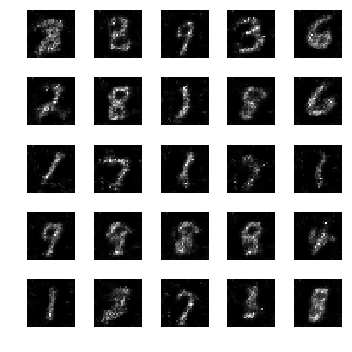

epoch: 461, time: 9.533820 | train_G_Loss: 0.337126, train_D_loss: 2.694577, train_acc: 0.830078
cv_G_Loss: 0.750514, cv_D_loss: 2.964026, cv_acc: 0.862000

epoch: 462, time: 9.569509 | train_G_Loss: 0.416070, train_D_loss: 2.531794, train_acc: 0.845703
cv_G_Loss: 0.251848, cv_D_loss: 2.603409, cv_acc: 0.888700

epoch: 463, time: 9.279910 | train_G_Loss: 0.621894, train_D_loss: 2.685361, train_acc: 0.841797
cv_G_Loss: 1.952620, cv_D_loss: 4.995344, cv_acc: 0.865700

epoch: 464, time: 9.527636 | train_G_Loss: 0.433335, train_D_loss: 2.782766, train_acc: 0.818359
cv_G_Loss: 0.575859, cv_D_loss: 2.649433, cv_acc: 0.887200

epoch: 465, time: 9.464456 | train_G_Loss: 0.386321, train_D_loss: 2.728596, train_acc: 0.859375
cv_G_Loss: 0.486364, cv_D_loss: 2.587108, cv_acc: 0.887200

epoch: 466, time: 9.537292 | train_G_Loss: 0.321454, train_D_loss: 2.617544, train_acc: 0.894531
cv_G_Loss: 0.263967, cv_D_loss: 2.630628, cv_acc: 0.874500

epoch: 467, time: 9.545375 | train_G_Loss: 0.340245, train

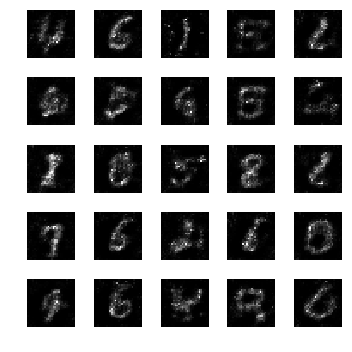

epoch: 471, time: 9.501425 | train_G_Loss: 0.410514, train_D_loss: 2.421681, train_acc: 0.880859
cv_G_Loss: 0.554813, cv_D_loss: 2.610426, cv_acc: 0.886500

epoch: 472, time: 9.546441 | train_G_Loss: 0.372037, train_D_loss: 2.596418, train_acc: 0.853516
cv_G_Loss: 0.460329, cv_D_loss: 2.594071, cv_acc: 0.867600

epoch: 473, time: 9.426980 | train_G_Loss: 0.367186, train_D_loss: 2.823481, train_acc: 0.869141
cv_G_Loss: 0.728157, cv_D_loss: 2.896055, cv_acc: 0.856000

epoch: 474, time: 9.396900 | train_G_Loss: 0.330903, train_D_loss: 2.637308, train_acc: 0.886719
cv_G_Loss: 0.243151, cv_D_loss: 2.652052, cv_acc: 0.876100

epoch: 475, time: 9.493330 | train_G_Loss: 0.398122, train_D_loss: 2.518408, train_acc: 0.900391
cv_G_Loss: 1.670377, cv_D_loss: 4.381221, cv_acc: 0.854900

epoch: 476, time: 8.797284 | train_G_Loss: 0.394381, train_D_loss: 2.466379, train_acc: 0.882812
cv_G_Loss: 0.146751, cv_D_loss: 2.876754, cv_acc: 0.885000

epoch: 477, time: 8.576015 | train_G_Loss: 0.346229, train

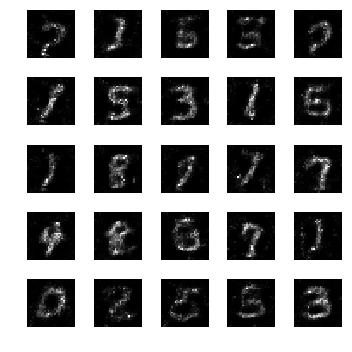

epoch: 481, time: 9.561385 | train_G_Loss: 0.396991, train_D_loss: 2.625090, train_acc: 0.826172
cv_G_Loss: 0.183286, cv_D_loss: 2.778653, cv_acc: 0.876700

epoch: 482, time: 9.648137 | train_G_Loss: 0.285398, train_D_loss: 2.711203, train_acc: 0.869141
cv_G_Loss: 0.225714, cv_D_loss: 2.695457, cv_acc: 0.854500

epoch: 483, time: 9.290332 | train_G_Loss: 0.269719, train_D_loss: 2.546871, train_acc: 0.890625
cv_G_Loss: 0.179729, cv_D_loss: 2.795871, cv_acc: 0.871500

epoch: 484, time: 9.461795 | train_G_Loss: 0.364505, train_D_loss: 2.684683, train_acc: 0.890625
cv_G_Loss: 0.178508, cv_D_loss: 2.732086, cv_acc: 0.884200

epoch: 485, time: 9.586755 | train_G_Loss: 0.382299, train_D_loss: 2.578741, train_acc: 0.896484
cv_G_Loss: 0.860672, cv_D_loss: 2.895078, cv_acc: 0.887300

epoch: 486, time: 9.462594 | train_G_Loss: 0.401221, train_D_loss: 2.472464, train_acc: 0.921875
cv_G_Loss: 0.351113, cv_D_loss: 2.521032, cv_acc: 0.888300

epoch: 487, time: 9.446892 | train_G_Loss: 0.324596, train

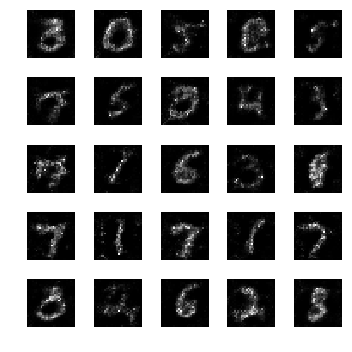

epoch: 491, time: 9.494907 | train_G_Loss: 0.344223, train_D_loss: 2.531514, train_acc: 0.898438
cv_G_Loss: 0.424301, cv_D_loss: 2.538215, cv_acc: 0.887000

epoch: 492, time: 9.396204 | train_G_Loss: 0.481346, train_D_loss: 2.539567, train_acc: 0.902344
cv_G_Loss: 0.868945, cv_D_loss: 2.963559, cv_acc: 0.887000

epoch: 493, time: 9.576908 | train_G_Loss: 0.402055, train_D_loss: 2.411600, train_acc: 0.886719
cv_G_Loss: 0.167841, cv_D_loss: 2.936447, cv_acc: 0.834900

epoch: 494, time: 9.314409 | train_G_Loss: 0.308900, train_D_loss: 2.545399, train_acc: 0.855469
cv_G_Loss: 0.849066, cv_D_loss: 2.884559, cv_acc: 0.878000

epoch: 495, time: 9.552750 | train_G_Loss: 0.296013, train_D_loss: 2.782129, train_acc: 0.835938
cv_G_Loss: 0.276546, cv_D_loss: 2.602369, cv_acc: 0.873300

epoch: 496, time: 9.511262 | train_G_Loss: 0.502486, train_D_loss: 2.569557, train_acc: 0.871094
cv_G_Loss: 1.173118, cv_D_loss: 3.716036, cv_acc: 0.810800

epoch: 497, time: 9.432899 | train_G_Loss: 0.370595, train

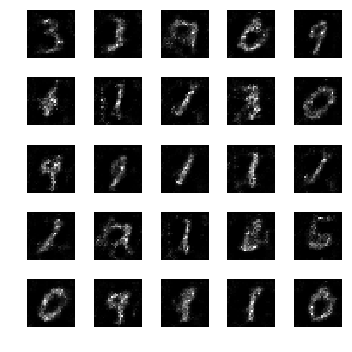

epoch: 501, time: 9.507868 | train_G_Loss: 0.399547, train_D_loss: 2.677342, train_acc: 0.912109
cv_G_Loss: 0.617195, cv_D_loss: 2.679250, cv_acc: 0.880300

epoch: 502, time: 9.613885 | train_G_Loss: 0.433795, train_D_loss: 2.348374, train_acc: 0.898438
cv_G_Loss: 0.449578, cv_D_loss: 2.557787, cv_acc: 0.877000

epoch: 503, time: 9.746173 | train_G_Loss: 0.317705, train_D_loss: 2.460378, train_acc: 0.875000
cv_G_Loss: 0.233386, cv_D_loss: 2.641461, cv_acc: 0.878700

epoch: 504, time: 9.417464 | train_G_Loss: 0.371316, train_D_loss: 2.484274, train_acc: 0.859375
cv_G_Loss: 0.372856, cv_D_loss: 2.548863, cv_acc: 0.875000

epoch: 505, time: 9.519777 | train_G_Loss: 0.415958, train_D_loss: 2.519034, train_acc: 0.914062
cv_G_Loss: 0.582882, cv_D_loss: 2.635166, cv_acc: 0.884700

epoch: 506, time: 9.530067 | train_G_Loss: 0.414837, train_D_loss: 2.330756, train_acc: 0.890625
cv_G_Loss: 0.445016, cv_D_loss: 2.507258, cv_acc: 0.892500
Model saved

epoch: 507, time: 9.578981 | train_G_Loss: 0.3

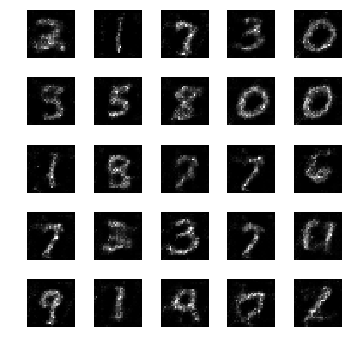

epoch: 511, time: 9.546498 | train_G_Loss: 0.387651, train_D_loss: 2.587648, train_acc: 0.898438
cv_G_Loss: 0.237914, cv_D_loss: 2.615747, cv_acc: 0.886600

epoch: 512, time: 9.624300 | train_G_Loss: 0.384990, train_D_loss: 2.691213, train_acc: 0.902344
cv_G_Loss: 0.335809, cv_D_loss: 2.508337, cv_acc: 0.891200

epoch: 513, time: 9.543978 | train_G_Loss: 0.521309, train_D_loss: 2.470077, train_acc: 0.890625
cv_G_Loss: 0.866747, cv_D_loss: 2.980486, cv_acc: 0.875900

epoch: 514, time: 9.498256 | train_G_Loss: 0.298279, train_D_loss: 2.422317, train_acc: 0.871094
cv_G_Loss: 0.336610, cv_D_loss: 2.523899, cv_acc: 0.884700

epoch: 515, time: 9.350703 | train_G_Loss: 0.278953, train_D_loss: 2.811906, train_acc: 0.876953
cv_G_Loss: 0.237134, cv_D_loss: 2.575505, cv_acc: 0.895600
Model saved

epoch: 516, time: 9.411656 | train_G_Loss: 0.335510, train_D_loss: 2.504673, train_acc: 0.880859
cv_G_Loss: 0.256810, cv_D_loss: 2.602914, cv_acc: 0.890000

epoch: 517, time: 9.478791 | train_G_Loss: 0.4

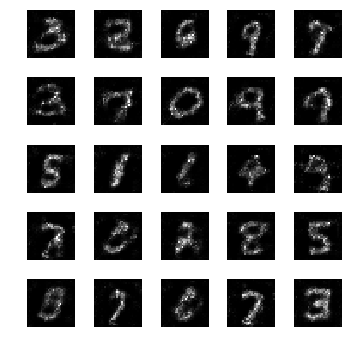

epoch: 521, time: 9.612414 | train_G_Loss: 0.264872, train_D_loss: 2.868256, train_acc: 0.861328
cv_G_Loss: 0.213067, cv_D_loss: 2.823164, cv_acc: 0.833300

epoch: 522, time: 9.605719 | train_G_Loss: 0.337851, train_D_loss: 2.390258, train_acc: 0.875000
cv_G_Loss: 0.284839, cv_D_loss: 2.510114, cv_acc: 0.891900

epoch: 523, time: 9.420469 | train_G_Loss: 0.454939, train_D_loss: 2.555193, train_acc: 0.880859
cv_G_Loss: 0.596493, cv_D_loss: 2.595093, cv_acc: 0.895100

epoch: 524, time: 9.659472 | train_G_Loss: 0.390287, train_D_loss: 2.746202, train_acc: 0.867188
cv_G_Loss: 0.242192, cv_D_loss: 2.583346, cv_acc: 0.885700

epoch: 525, time: 9.610157 | train_G_Loss: 0.316370, train_D_loss: 2.435335, train_acc: 0.867188
cv_G_Loss: 0.358430, cv_D_loss: 2.495944, cv_acc: 0.892000

epoch: 526, time: 9.320496 | train_G_Loss: 0.340242, train_D_loss: 2.485271, train_acc: 0.875000
cv_G_Loss: 0.278714, cv_D_loss: 2.592726, cv_acc: 0.888400

epoch: 527, time: 9.400860 | train_G_Loss: 0.281296, train

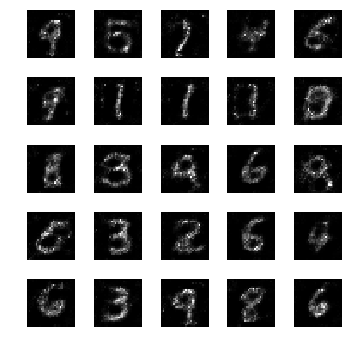

epoch: 531, time: 9.512884 | train_G_Loss: 0.349350, train_D_loss: 2.538976, train_acc: 0.861328
cv_G_Loss: 0.279198, cv_D_loss: 2.520895, cv_acc: 0.891400

epoch: 532, time: 9.363870 | train_G_Loss: 0.274153, train_D_loss: 2.564664, train_acc: 0.900391
cv_G_Loss: 0.629181, cv_D_loss: 2.658361, cv_acc: 0.879800

epoch: 533, time: 9.426544 | train_G_Loss: 0.394924, train_D_loss: 2.205558, train_acc: 0.859375
cv_G_Loss: 0.274046, cv_D_loss: 2.560273, cv_acc: 0.894200

epoch: 534, time: 9.491213 | train_G_Loss: 0.413012, train_D_loss: 2.709563, train_acc: 0.871094
cv_G_Loss: 0.421280, cv_D_loss: 2.662940, cv_acc: 0.851500

epoch: 535, time: 9.471238 | train_G_Loss: 0.541060, train_D_loss: 2.635450, train_acc: 0.880859
cv_G_Loss: 1.303507, cv_D_loss: 3.770497, cv_acc: 0.875400

epoch: 536, time: 9.518765 | train_G_Loss: 0.411789, train_D_loss: 2.448515, train_acc: 0.875000
cv_G_Loss: 0.196854, cv_D_loss: 2.672784, cv_acc: 0.887000

epoch: 537, time: 9.335187 | train_G_Loss: 0.312805, train

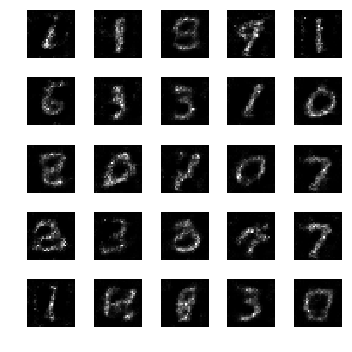

epoch: 541, time: 9.457330 | train_G_Loss: 0.511967, train_D_loss: 2.584584, train_acc: 0.904297
cv_G_Loss: 0.456392, cv_D_loss: 2.468681, cv_acc: 0.888100

epoch: 542, time: 9.662036 | train_G_Loss: 0.362607, train_D_loss: 2.307081, train_acc: 0.919922
cv_G_Loss: 0.221922, cv_D_loss: 2.619219, cv_acc: 0.890700

epoch: 543, time: 9.344622 | train_G_Loss: 0.403471, train_D_loss: 2.473660, train_acc: 0.917969
cv_G_Loss: 0.488146, cv_D_loss: 2.727866, cv_acc: 0.840700

epoch: 544, time: 9.552017 | train_G_Loss: 0.412378, train_D_loss: 2.357358, train_acc: 0.925781
cv_G_Loss: 0.973609, cv_D_loss: 3.080286, cv_acc: 0.881200

epoch: 545, time: 9.491625 | train_G_Loss: 0.279707, train_D_loss: 2.346261, train_acc: 0.908203
cv_G_Loss: 0.173741, cv_D_loss: 2.741215, cv_acc: 0.892900

epoch: 546, time: 9.506105 | train_G_Loss: 0.421772, train_D_loss: 2.288243, train_acc: 0.882812
cv_G_Loss: 0.270247, cv_D_loss: 2.602458, cv_acc: 0.866800

epoch: 547, time: 9.526115 | train_G_Loss: 0.320269, train

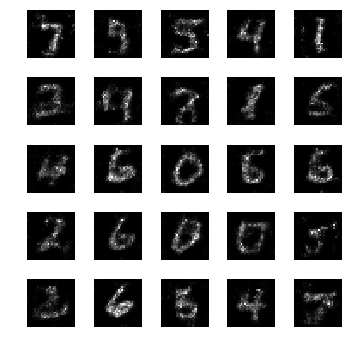

epoch: 551, time: 9.670230 | train_G_Loss: 0.388484, train_D_loss: 2.360095, train_acc: 0.941406
cv_G_Loss: 0.273890, cv_D_loss: 2.514919, cv_acc: 0.893700

epoch: 552, time: 9.650492 | train_G_Loss: 0.435402, train_D_loss: 2.093493, train_acc: 0.933594
cv_G_Loss: 0.656653, cv_D_loss: 2.741160, cv_acc: 0.888800

epoch: 553, time: 9.561600 | train_G_Loss: 0.391488, train_D_loss: 2.210047, train_acc: 0.949219
cv_G_Loss: 0.392794, cv_D_loss: 2.535984, cv_acc: 0.874400

epoch: 554, time: 9.423934 | train_G_Loss: 0.458203, train_D_loss: 2.428787, train_acc: 0.962891
cv_G_Loss: 0.970724, cv_D_loss: 3.263721, cv_acc: 0.825400

epoch: 555, time: 9.438407 | train_G_Loss: 0.353623, train_D_loss: 2.279166, train_acc: 0.947266
cv_G_Loss: 0.498572, cv_D_loss: 2.528839, cv_acc: 0.895700

epoch: 556, time: 9.397634 | train_G_Loss: 0.308030, train_D_loss: 2.622266, train_acc: 0.935547
cv_G_Loss: 0.182475, cv_D_loss: 2.706771, cv_acc: 0.876000

epoch: 557, time: 9.483639 | train_G_Loss: 0.422064, train

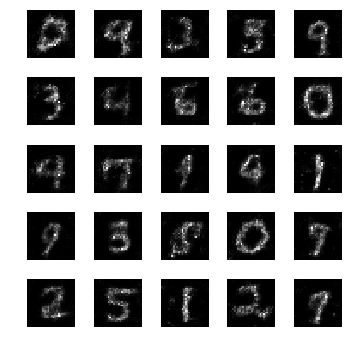

epoch: 561, time: 9.571100 | train_G_Loss: 0.262099, train_D_loss: 2.671331, train_acc: 0.929688
cv_G_Loss: 0.332116, cv_D_loss: 2.545012, cv_acc: 0.876100

epoch: 562, time: 9.491537 | train_G_Loss: 0.481038, train_D_loss: 2.370852, train_acc: 0.919922
cv_G_Loss: 0.648963, cv_D_loss: 2.576510, cv_acc: 0.898400
Model saved

epoch: 563, time: 9.541208 | train_G_Loss: 0.427574, train_D_loss: 2.454912, train_acc: 0.886719
cv_G_Loss: 0.216036, cv_D_loss: 2.658271, cv_acc: 0.877700

epoch: 564, time: 9.221524 | train_G_Loss: 0.386427, train_D_loss: 2.446311, train_acc: 0.878906
cv_G_Loss: 0.573265, cv_D_loss: 2.569757, cv_acc: 0.896000

epoch: 565, time: 9.382171 | train_G_Loss: 0.371340, train_D_loss: 2.426666, train_acc: 0.900391
cv_G_Loss: 0.352167, cv_D_loss: 2.516788, cv_acc: 0.883100

epoch: 566, time: 9.538179 | train_G_Loss: 0.366875, train_D_loss: 2.627932, train_acc: 0.908203
cv_G_Loss: 0.204160, cv_D_loss: 2.655920, cv_acc: 0.887700

epoch: 567, time: 9.767582 | train_G_Loss: 0.3

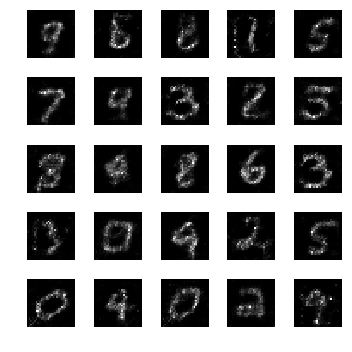

epoch: 571, time: 9.623088 | train_G_Loss: 0.325379, train_D_loss: 2.514363, train_acc: 0.884766
cv_G_Loss: 0.169142, cv_D_loss: 2.731632, cv_acc: 0.896200

epoch: 572, time: 9.644093 | train_G_Loss: 0.382415, train_D_loss: 2.528867, train_acc: 0.894531
cv_G_Loss: 0.263651, cv_D_loss: 2.619132, cv_acc: 0.859300

epoch: 573, time: 9.445453 | train_G_Loss: 0.716377, train_D_loss: 2.762078, train_acc: 0.914062
cv_G_Loss: 1.220751, cv_D_loss: 3.456840, cv_acc: 0.894300

epoch: 574, time: 9.462930 | train_G_Loss: 0.565950, train_D_loss: 2.297058, train_acc: 0.917969
cv_G_Loss: 0.427136, cv_D_loss: 2.475040, cv_acc: 0.892700

epoch: 575, time: 9.487715 | train_G_Loss: 0.346957, train_D_loss: 2.416764, train_acc: 0.916016
cv_G_Loss: 0.405645, cv_D_loss: 2.415163, cv_acc: 0.899900
Model saved

epoch: 576, time: 9.433794 | train_G_Loss: 0.331418, train_D_loss: 2.417655, train_acc: 0.925781
cv_G_Loss: 0.244412, cv_D_loss: 2.527135, cv_acc: 0.898800

epoch: 577, time: 9.630939 | train_G_Loss: 0.4

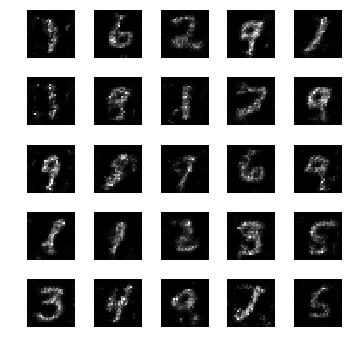

epoch: 581, time: 9.504304 | train_G_Loss: 0.273441, train_D_loss: 2.607347, train_acc: 0.900391
cv_G_Loss: 0.064275, cv_D_loss: 3.412122, cv_acc: 0.892600

epoch: 582, time: 9.554268 | train_G_Loss: 0.374720, train_D_loss: 2.411226, train_acc: 0.886719
cv_G_Loss: 0.649294, cv_D_loss: 2.644677, cv_acc: 0.889600

epoch: 583, time: 9.516083 | train_G_Loss: 0.342107, train_D_loss: 2.457956, train_acc: 0.886719
cv_G_Loss: 0.214083, cv_D_loss: 2.585141, cv_acc: 0.891700

epoch: 584, time: 9.460355 | train_G_Loss: 0.347559, train_D_loss: 2.712400, train_acc: 0.849609
cv_G_Loss: 0.301459, cv_D_loss: 2.479534, cv_acc: 0.895600

epoch: 585, time: 9.402088 | train_G_Loss: 0.344892, train_D_loss: 2.565330, train_acc: 0.882812
cv_G_Loss: 0.255832, cv_D_loss: 2.557543, cv_acc: 0.888300

epoch: 586, time: 9.523085 | train_G_Loss: 0.385474, train_D_loss: 2.400427, train_acc: 0.912109
cv_G_Loss: 0.799828, cv_D_loss: 2.784721, cv_acc: 0.895500

epoch: 587, time: 9.418945 | train_G_Loss: 0.352485, train

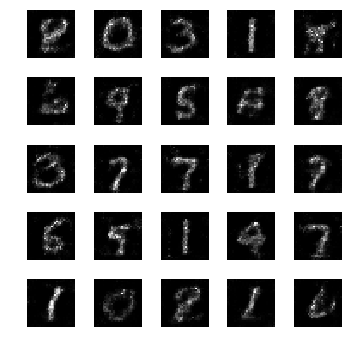

epoch: 591, time: 9.257169 | train_G_Loss: 0.366522, train_D_loss: 2.787568, train_acc: 0.892578
cv_G_Loss: 0.236524, cv_D_loss: 2.568589, cv_acc: 0.893900

epoch: 592, time: 9.523464 | train_G_Loss: 0.416750, train_D_loss: 2.330445, train_acc: 0.906250
cv_G_Loss: 0.454275, cv_D_loss: 2.609789, cv_acc: 0.874300

epoch: 593, time: 9.567449 | train_G_Loss: 0.331525, train_D_loss: 2.412289, train_acc: 0.892578
cv_G_Loss: 0.863958, cv_D_loss: 2.870110, cv_acc: 0.896000

epoch: 594, time: 9.509644 | train_G_Loss: 0.334184, train_D_loss: 2.445072, train_acc: 0.859375
cv_G_Loss: 0.174548, cv_D_loss: 2.732768, cv_acc: 0.888900

epoch: 595, time: 9.477329 | train_G_Loss: 0.345703, train_D_loss: 2.566332, train_acc: 0.894531
cv_G_Loss: 0.583312, cv_D_loss: 2.560716, cv_acc: 0.899500

epoch: 596, time: 9.443906 | train_G_Loss: 0.419823, train_D_loss: 2.382447, train_acc: 0.917969
cv_G_Loss: 1.779065, cv_D_loss: 4.497425, cv_acc: 0.888500

epoch: 597, time: 9.358031 | train_G_Loss: 0.470911, train

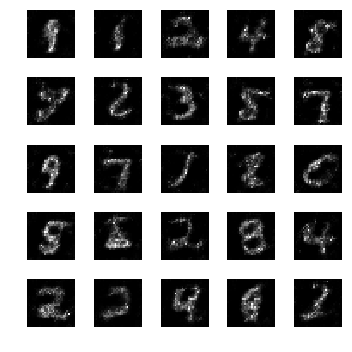

epoch: 601, time: 9.633499 | train_G_Loss: 0.367990, train_D_loss: 2.541867, train_acc: 0.902344
cv_G_Loss: 0.730683, cv_D_loss: 2.792360, cv_acc: 0.892900

epoch: 602, time: 9.649706 | train_G_Loss: 0.468128, train_D_loss: 2.430748, train_acc: 0.919922
cv_G_Loss: 0.585790, cv_D_loss: 2.576741, cv_acc: 0.900200

epoch: 603, time: 9.630132 | train_G_Loss: 0.417904, train_D_loss: 2.253936, train_acc: 0.927734
cv_G_Loss: 0.658236, cv_D_loss: 2.647798, cv_acc: 0.898700

epoch: 604, time: 9.300621 | train_G_Loss: 0.423292, train_D_loss: 2.552354, train_acc: 0.931641
cv_G_Loss: 0.525545, cv_D_loss: 2.491989, cv_acc: 0.901000
Model saved

epoch: 605, time: 9.372082 | train_G_Loss: 0.386431, train_D_loss: 2.278705, train_acc: 0.919922
cv_G_Loss: 0.436277, cv_D_loss: 2.494154, cv_acc: 0.893500

epoch: 606, time: 9.578138 | train_G_Loss: 0.351800, train_D_loss: 2.437330, train_acc: 0.898438
cv_G_Loss: 0.394356, cv_D_loss: 2.448407, cv_acc: 0.900300

epoch: 607, time: 9.450626 | train_G_Loss: 0.4

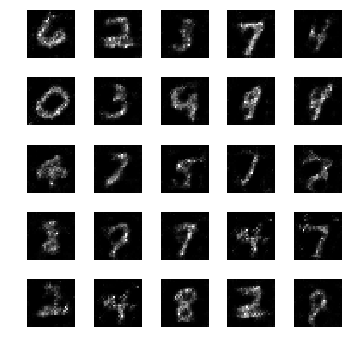

epoch: 611, time: 9.708720 | train_G_Loss: 0.328533, train_D_loss: 2.511266, train_acc: 0.882812
cv_G_Loss: 0.321263, cv_D_loss: 2.485223, cv_acc: 0.896300

epoch: 612, time: 9.621351 | train_G_Loss: 0.350256, train_D_loss: 2.717002, train_acc: 0.882812
cv_G_Loss: 0.457196, cv_D_loss: 2.483984, cv_acc: 0.899000

epoch: 613, time: 9.528843 | train_G_Loss: 0.407629, train_D_loss: 2.244076, train_acc: 0.898438
cv_G_Loss: 0.389053, cv_D_loss: 2.433735, cv_acc: 0.902700
Model saved

epoch: 614, time: 9.440306 | train_G_Loss: 0.359791, train_D_loss: 2.413216, train_acc: 0.927734
cv_G_Loss: 0.211711, cv_D_loss: 2.595226, cv_acc: 0.898700

epoch: 615, time: 9.438429 | train_G_Loss: 0.433990, train_D_loss: 2.328992, train_acc: 0.917969
cv_G_Loss: 0.478559, cv_D_loss: 2.451091, cv_acc: 0.897400

epoch: 616, time: 9.410283 | train_G_Loss: 0.303009, train_D_loss: 2.636688, train_acc: 0.873047
cv_G_Loss: 0.280935, cv_D_loss: 2.490091, cv_acc: 0.901000

epoch: 617, time: 9.598994 | train_G_Loss: 0.3

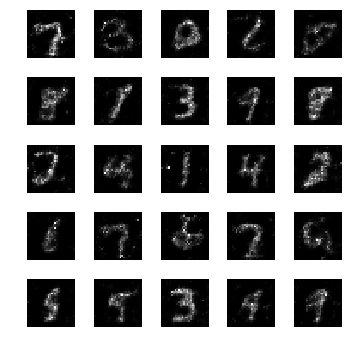

epoch: 621, time: 9.574765 | train_G_Loss: 0.410968, train_D_loss: 2.418478, train_acc: 0.902344
cv_G_Loss: 1.123312, cv_D_loss: 3.325302, cv_acc: 0.886000

epoch: 622, time: 9.557207 | train_G_Loss: 0.349700, train_D_loss: 2.366667, train_acc: 0.878906
cv_G_Loss: 0.152923, cv_D_loss: 2.799934, cv_acc: 0.886900

epoch: 623, time: 9.590543 | train_G_Loss: 0.352098, train_D_loss: 2.559070, train_acc: 0.882812
cv_G_Loss: 1.199286, cv_D_loss: 3.495485, cv_acc: 0.876200

epoch: 624, time: 9.490909 | train_G_Loss: 0.339184, train_D_loss: 2.613487, train_acc: 0.878906
cv_G_Loss: 0.465981, cv_D_loss: 2.643003, cv_acc: 0.864700

epoch: 625, time: 9.364777 | train_G_Loss: 0.332218, train_D_loss: 2.568281, train_acc: 0.890625
cv_G_Loss: 0.192852, cv_D_loss: 2.663311, cv_acc: 0.896600

epoch: 626, time: 9.362328 | train_G_Loss: 0.380699, train_D_loss: 2.440048, train_acc: 0.904297
cv_G_Loss: 0.401305, cv_D_loss: 2.707386, cv_acc: 0.836800

epoch: 627, time: 9.492210 | train_G_Loss: 0.375206, train

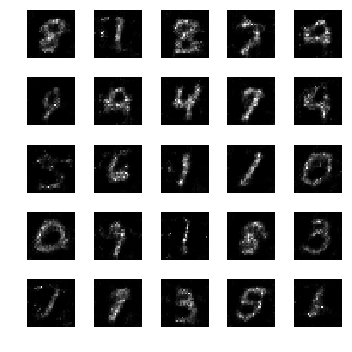

epoch: 631, time: 9.522423 | train_G_Loss: 0.492841, train_D_loss: 2.537350, train_acc: 0.882812
cv_G_Loss: 0.774751, cv_D_loss: 2.822782, cv_acc: 0.897900

epoch: 632, time: 9.592942 | train_G_Loss: 0.377241, train_D_loss: 2.588782, train_acc: 0.876953
cv_G_Loss: 0.198505, cv_D_loss: 2.634105, cv_acc: 0.899600

epoch: 633, time: 9.568126 | train_G_Loss: 0.398320, train_D_loss: 2.701767, train_acc: 0.886719
cv_G_Loss: 0.316167, cv_D_loss: 2.456912, cv_acc: 0.903200
Model saved

epoch: 634, time: 9.463186 | train_G_Loss: 0.386846, train_D_loss: 2.349488, train_acc: 0.923828
cv_G_Loss: 0.547195, cv_D_loss: 2.607542, cv_acc: 0.889400

epoch: 635, time: 9.476297 | train_G_Loss: 0.374796, train_D_loss: 2.441935, train_acc: 0.921875
cv_G_Loss: 0.182091, cv_D_loss: 2.741087, cv_acc: 0.882400

epoch: 636, time: 9.583011 | train_G_Loss: 0.366310, train_D_loss: 2.290372, train_acc: 0.917969
cv_G_Loss: 0.829877, cv_D_loss: 2.904734, cv_acc: 0.876400

epoch: 637, time: 9.395700 | train_G_Loss: 0.3

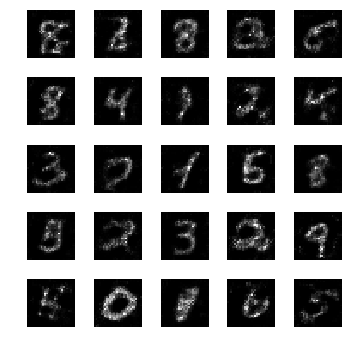

epoch: 641, time: 9.430118 | train_G_Loss: 0.298580, train_D_loss: 2.419405, train_acc: 0.875000
cv_G_Loss: 0.118506, cv_D_loss: 2.937239, cv_acc: 0.895400

epoch: 642, time: 9.488973 | train_G_Loss: 0.330965, train_D_loss: 2.698518, train_acc: 0.857422
cv_G_Loss: 0.333391, cv_D_loss: 2.442672, cv_acc: 0.904200
Model saved

epoch: 643, time: 9.500519 | train_G_Loss: 0.373174, train_D_loss: 2.769217, train_acc: 0.878906
cv_G_Loss: 0.343235, cv_D_loss: 2.474384, cv_acc: 0.899200

epoch: 644, time: 9.466285 | train_G_Loss: 0.339480, train_D_loss: 2.545817, train_acc: 0.859375
cv_G_Loss: 0.313289, cv_D_loss: 2.498836, cv_acc: 0.898300

epoch: 645, time: 9.539527 | train_G_Loss: 0.319565, train_D_loss: 2.506546, train_acc: 0.869141
cv_G_Loss: 0.896107, cv_D_loss: 2.925480, cv_acc: 0.896700

epoch: 646, time: 9.487111 | train_G_Loss: 0.388479, train_D_loss: 2.542869, train_acc: 0.875000
cv_G_Loss: 0.502197, cv_D_loss: 2.505314, cv_acc: 0.903500

epoch: 647, time: 9.551302 | train_G_Loss: 0.3

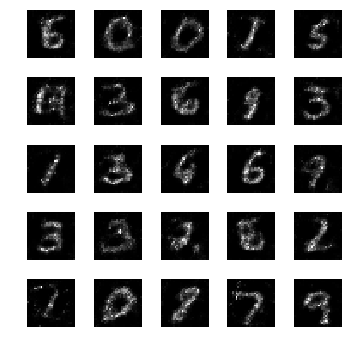

epoch: 651, time: 9.499789 | train_G_Loss: 0.469405, train_D_loss: 2.707997, train_acc: 0.917969
cv_G_Loss: 0.352446, cv_D_loss: 2.454017, cv_acc: 0.902500

epoch: 652, time: 9.515981 | train_G_Loss: 0.343066, train_D_loss: 2.648687, train_acc: 0.912109
cv_G_Loss: 0.424176, cv_D_loss: 2.447776, cv_acc: 0.898600

epoch: 653, time: 9.430062 | train_G_Loss: 0.333459, train_D_loss: 2.316179, train_acc: 0.908203
cv_G_Loss: 0.454499, cv_D_loss: 2.475389, cv_acc: 0.904800
Model saved

epoch: 654, time: 9.464739 | train_G_Loss: 0.491648, train_D_loss: 2.544243, train_acc: 0.925781
cv_G_Loss: 0.907434, cv_D_loss: 3.175790, cv_acc: 0.835200

epoch: 655, time: 9.410669 | train_G_Loss: 0.335786, train_D_loss: 2.376483, train_acc: 0.949219
cv_G_Loss: 0.158522, cv_D_loss: 2.719627, cv_acc: 0.901200

epoch: 656, time: 9.561107 | train_G_Loss: 0.423773, train_D_loss: 2.373960, train_acc: 0.925781
cv_G_Loss: 0.593563, cv_D_loss: 2.596262, cv_acc: 0.895000

epoch: 657, time: 9.386359 | train_G_Loss: 0.3

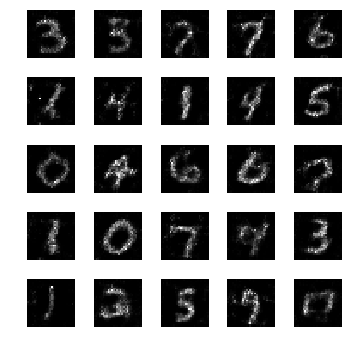

epoch: 661, time: 9.683065 | train_G_Loss: 0.369946, train_D_loss: 2.590920, train_acc: 0.912109
cv_G_Loss: 0.330732, cv_D_loss: 2.454053, cv_acc: 0.900600

epoch: 662, time: 9.536074 | train_G_Loss: 0.449989, train_D_loss: 2.291708, train_acc: 0.904297
cv_G_Loss: 0.512622, cv_D_loss: 2.528024, cv_acc: 0.885800

epoch: 663, time: 9.538587 | train_G_Loss: 0.369296, train_D_loss: 2.604429, train_acc: 0.900391
cv_G_Loss: 0.436847, cv_D_loss: 2.443845, cv_acc: 0.901900

epoch: 664, time: 9.595205 | train_G_Loss: 0.415935, train_D_loss: 2.425611, train_acc: 0.914062
cv_G_Loss: 0.569097, cv_D_loss: 2.535135, cv_acc: 0.899000

epoch: 665, time: 9.625208 | train_G_Loss: 0.312457, train_D_loss: 2.382869, train_acc: 0.912109
cv_G_Loss: 0.132742, cv_D_loss: 2.947671, cv_acc: 0.871200

epoch: 666, time: 9.420890 | train_G_Loss: 0.487010, train_D_loss: 2.295312, train_acc: 0.880859
cv_G_Loss: 0.568614, cv_D_loss: 2.576445, cv_acc: 0.899700

epoch: 667, time: 9.560645 | train_G_Loss: 0.469712, train

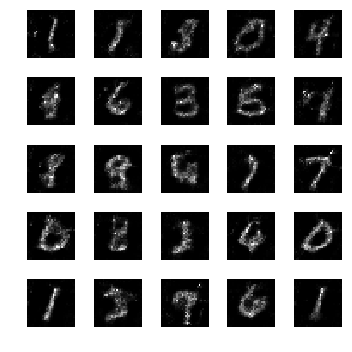

epoch: 671, time: 9.685856 | train_G_Loss: 0.377448, train_D_loss: 2.381799, train_acc: 0.910156
cv_G_Loss: 0.411389, cv_D_loss: 2.425492, cv_acc: 0.906100

epoch: 672, time: 9.543554 | train_G_Loss: 0.533901, train_D_loss: 2.340698, train_acc: 0.933594
cv_G_Loss: 0.675364, cv_D_loss: 2.679165, cv_acc: 0.899800

epoch: 673, time: 9.543198 | train_G_Loss: 0.389189, train_D_loss: 2.380467, train_acc: 0.896484
cv_G_Loss: 0.729948, cv_D_loss: 2.687249, cv_acc: 0.906500

epoch: 674, time: 9.472504 | train_G_Loss: 0.267945, train_D_loss: 2.813579, train_acc: 0.896484
cv_G_Loss: 0.234026, cv_D_loss: 2.568361, cv_acc: 0.893600

epoch: 675, time: 9.535547 | train_G_Loss: 0.479973, train_D_loss: 2.374793, train_acc: 0.896484
cv_G_Loss: 0.690290, cv_D_loss: 2.726051, cv_acc: 0.891000

epoch: 676, time: 9.342507 | train_G_Loss: 0.305521, train_D_loss: 2.584075, train_acc: 0.898438
cv_G_Loss: 0.117707, cv_D_loss: 2.905317, cv_acc: 0.904300

epoch: 677, time: 9.574167 | train_G_Loss: 0.376096, train

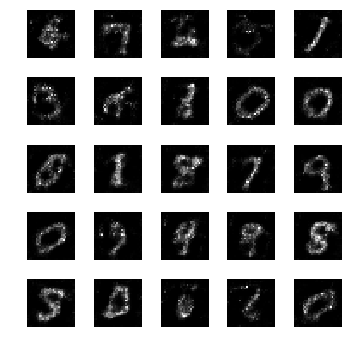

epoch: 681, time: 9.613092 | train_G_Loss: 0.319012, train_D_loss: 2.644738, train_acc: 0.888672
cv_G_Loss: 0.343189, cv_D_loss: 2.491090, cv_acc: 0.902500

epoch: 682, time: 9.481976 | train_G_Loss: 0.346344, train_D_loss: 2.342215, train_acc: 0.900391
cv_G_Loss: 0.242710, cv_D_loss: 2.547890, cv_acc: 0.901600

epoch: 683, time: 9.610082 | train_G_Loss: 0.352660, train_D_loss: 2.399766, train_acc: 0.878906
cv_G_Loss: 0.150480, cv_D_loss: 2.761435, cv_acc: 0.901500

epoch: 684, time: 9.715647 | train_G_Loss: 0.459848, train_D_loss: 2.478946, train_acc: 0.884766
cv_G_Loss: 0.608313, cv_D_loss: 2.519381, cv_acc: 0.904200

epoch: 685, time: 9.589198 | train_G_Loss: 0.341377, train_D_loss: 2.322073, train_acc: 0.904297
cv_G_Loss: 0.248192, cv_D_loss: 2.502166, cv_acc: 0.906100

epoch: 686, time: 9.458435 | train_G_Loss: 0.348896, train_D_loss: 2.453417, train_acc: 0.882812
cv_G_Loss: 0.199724, cv_D_loss: 2.631567, cv_acc: 0.897100

epoch: 687, time: 9.284852 | train_G_Loss: 0.458222, train

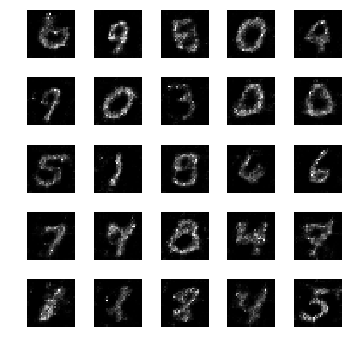

epoch: 691, time: 9.787556 | train_G_Loss: 0.346718, train_D_loss: 2.478655, train_acc: 0.931641
cv_G_Loss: 0.265137, cv_D_loss: 2.538349, cv_acc: 0.898700

epoch: 692, time: 9.440072 | train_G_Loss: 0.384255, train_D_loss: 2.313096, train_acc: 0.894531
cv_G_Loss: 0.722123, cv_D_loss: 2.663969, cv_acc: 0.904500

epoch: 693, time: 9.310520 | train_G_Loss: 0.719411, train_D_loss: 2.619876, train_acc: 0.927734
cv_G_Loss: 1.592388, cv_D_loss: 4.035762, cv_acc: 0.901900

epoch: 694, time: 9.509732 | train_G_Loss: 0.439816, train_D_loss: 2.314105, train_acc: 0.902344
cv_G_Loss: 0.612598, cv_D_loss: 2.543689, cv_acc: 0.903300

epoch: 695, time: 9.421318 | train_G_Loss: 0.308161, train_D_loss: 2.535815, train_acc: 0.882812
cv_G_Loss: 0.267975, cv_D_loss: 2.494497, cv_acc: 0.905000

epoch: 696, time: 9.662412 | train_G_Loss: 0.409720, train_D_loss: 2.596375, train_acc: 0.890625
cv_G_Loss: 0.594881, cv_D_loss: 2.529164, cv_acc: 0.909200
Model saved

epoch: 697, time: 9.494246 | train_G_Loss: 0.3

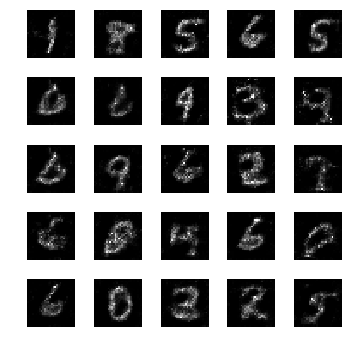

epoch: 701, time: 9.603933 | train_G_Loss: 0.383390, train_D_loss: 2.567983, train_acc: 0.890625
cv_G_Loss: 0.400978, cv_D_loss: 2.490152, cv_acc: 0.891000

epoch: 702, time: 9.529238 | train_G_Loss: 0.290939, train_D_loss: 2.721129, train_acc: 0.898438
cv_G_Loss: 0.122808, cv_D_loss: 2.938549, cv_acc: 0.881700

epoch: 703, time: 9.310645 | train_G_Loss: 0.369397, train_D_loss: 2.465880, train_acc: 0.904297
cv_G_Loss: 0.571809, cv_D_loss: 2.477608, cv_acc: 0.907300

epoch: 704, time: 9.588630 | train_G_Loss: 0.473301, train_D_loss: 2.245152, train_acc: 0.919922
cv_G_Loss: 1.055309, cv_D_loss: 3.130704, cv_acc: 0.907200

epoch: 705, time: 9.539188 | train_G_Loss: 0.339346, train_D_loss: 2.494119, train_acc: 0.908203
cv_G_Loss: 0.248713, cv_D_loss: 2.508616, cv_acc: 0.903000

epoch: 706, time: 9.393076 | train_G_Loss: 0.262322, train_D_loss: 2.459876, train_acc: 0.894531
cv_G_Loss: 0.292740, cv_D_loss: 2.475805, cv_acc: 0.906700

epoch: 707, time: 9.627457 | train_G_Loss: 0.282052, train

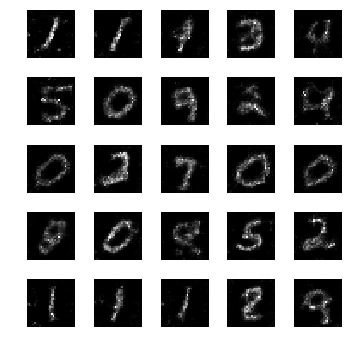

epoch: 711, time: 9.693079 | train_G_Loss: 0.260783, train_D_loss: 2.397506, train_acc: 0.888672
cv_G_Loss: 0.308591, cv_D_loss: 2.441200, cv_acc: 0.909200

epoch: 712, time: 9.554634 | train_G_Loss: 0.288482, train_D_loss: 2.566927, train_acc: 0.904297
cv_G_Loss: 0.163547, cv_D_loss: 2.701392, cv_acc: 0.906300

epoch: 713, time: 9.484638 | train_G_Loss: 0.318269, train_D_loss: 2.360764, train_acc: 0.908203
cv_G_Loss: 0.596200, cv_D_loss: 2.525271, cv_acc: 0.909200
Model saved

epoch: 714, time: 9.624720 | train_G_Loss: 0.369726, train_D_loss: 2.453682, train_acc: 0.917969
cv_G_Loss: 0.398964, cv_D_loss: 2.418330, cv_acc: 0.909900
Model saved

epoch: 715, time: 9.461713 | train_G_Loss: 0.398109, train_D_loss: 2.357535, train_acc: 0.941406
cv_G_Loss: 0.506184, cv_D_loss: 2.463672, cv_acc: 0.904900

epoch: 716, time: 9.566222 | train_G_Loss: 0.319787, train_D_loss: 2.467181, train_acc: 0.900391
cv_G_Loss: 0.311322, cv_D_loss: 2.424533, cv_acc: 0.910100
Model saved

epoch: 717, time: 9.43

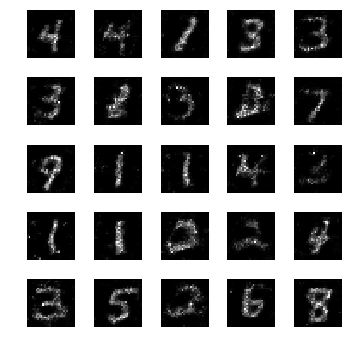

epoch: 721, time: 9.609965 | train_G_Loss: 0.478831, train_D_loss: 2.438543, train_acc: 0.914062
cv_G_Loss: 0.998113, cv_D_loss: 3.088382, cv_acc: 0.899800

epoch: 722, time: 9.410969 | train_G_Loss: 0.370531, train_D_loss: 2.400920, train_acc: 0.894531
cv_G_Loss: 0.457660, cv_D_loss: 2.430118, cv_acc: 0.907700

epoch: 723, time: 9.637127 | train_G_Loss: 0.301196, train_D_loss: 2.348203, train_acc: 0.910156
cv_G_Loss: 0.311194, cv_D_loss: 2.439009, cv_acc: 0.909800

epoch: 724, time: 9.697879 | train_G_Loss: 0.347970, train_D_loss: 2.380873, train_acc: 0.921875
cv_G_Loss: 0.442215, cv_D_loss: 2.422493, cv_acc: 0.910200
Model saved

epoch: 725, time: 9.536397 | train_G_Loss: 0.377633, train_D_loss: 2.411611, train_acc: 0.914062
cv_G_Loss: 0.504304, cv_D_loss: 2.489732, cv_acc: 0.905800

epoch: 726, time: 9.504019 | train_G_Loss: 0.343041, train_D_loss: 2.296414, train_acc: 0.902344
cv_G_Loss: 0.223217, cv_D_loss: 2.539141, cv_acc: 0.909100

epoch: 727, time: 9.491712 | train_G_Loss: 0.4

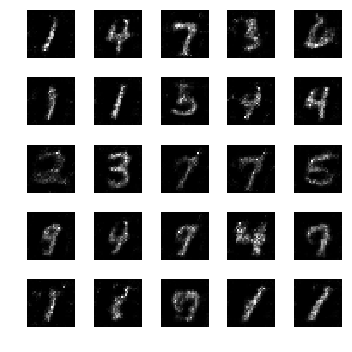

epoch: 731, time: 9.309342 | train_G_Loss: 0.548065, train_D_loss: 2.532562, train_acc: 0.914062
cv_G_Loss: 0.940259, cv_D_loss: 2.954205, cv_acc: 0.908300

epoch: 732, time: 9.330910 | train_G_Loss: 0.386606, train_D_loss: 2.618047, train_acc: 0.908203
cv_G_Loss: 0.489889, cv_D_loss: 2.454399, cv_acc: 0.905200

epoch: 733, time: 9.416178 | train_G_Loss: 0.391038, train_D_loss: 2.334509, train_acc: 0.910156
cv_G_Loss: 0.577992, cv_D_loss: 2.539780, cv_acc: 0.905700

epoch: 734, time: 9.557847 | train_G_Loss: 0.332371, train_D_loss: 2.505269, train_acc: 0.917969
cv_G_Loss: 1.091196, cv_D_loss: 3.198232, cv_acc: 0.896000

epoch: 735, time: 9.533981 | train_G_Loss: 0.385972, train_D_loss: 2.341880, train_acc: 0.912109
cv_G_Loss: 1.043323, cv_D_loss: 3.136997, cv_acc: 0.902800

epoch: 736, time: 9.500066 | train_G_Loss: 0.463093, train_D_loss: 2.444572, train_acc: 0.929688
cv_G_Loss: 2.217331, cv_D_loss: 5.414749, cv_acc: 0.826200

epoch: 737, time: 9.311215 | train_G_Loss: 0.384876, train

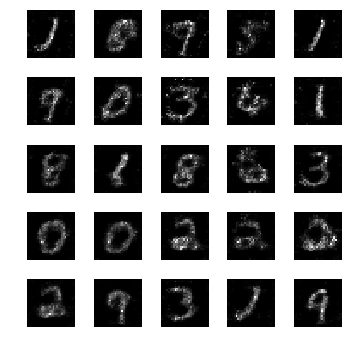

epoch: 741, time: 9.487898 | train_G_Loss: 0.416426, train_D_loss: 2.179936, train_acc: 0.951172
cv_G_Loss: 0.637495, cv_D_loss: 2.580962, cv_acc: 0.908300

epoch: 742, time: 9.670272 | train_G_Loss: 0.413832, train_D_loss: 2.300604, train_acc: 0.955078
cv_G_Loss: 0.717516, cv_D_loss: 2.748228, cv_acc: 0.887100

epoch: 743, time: 9.285722 | train_G_Loss: 0.358579, train_D_loss: 2.769226, train_acc: 0.931641
cv_G_Loss: 0.368149, cv_D_loss: 2.461771, cv_acc: 0.899800

epoch: 744, time: 9.393100 | train_G_Loss: 0.386201, train_D_loss: 2.340007, train_acc: 0.904297
cv_G_Loss: 0.420190, cv_D_loss: 2.441021, cv_acc: 0.908700

epoch: 745, time: 9.650695 | train_G_Loss: 0.330439, train_D_loss: 2.498457, train_acc: 0.910156
cv_G_Loss: 0.240411, cv_D_loss: 2.503099, cv_acc: 0.911200
Model saved

epoch: 746, time: 9.556059 | train_G_Loss: 0.347262, train_D_loss: 2.444468, train_acc: 0.923828
cv_G_Loss: 0.449626, cv_D_loss: 2.473044, cv_acc: 0.909100

epoch: 747, time: 9.351082 | train_G_Loss: 0.3

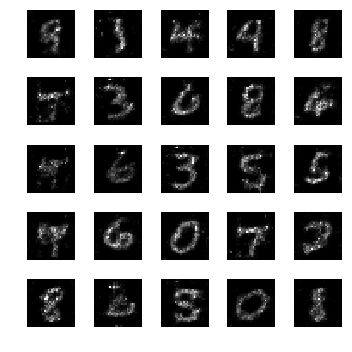

epoch: 751, time: 9.561588 | train_G_Loss: 0.380226, train_D_loss: 2.287596, train_acc: 0.910156
cv_G_Loss: 0.791524, cv_D_loss: 2.769776, cv_acc: 0.909300

epoch: 752, time: 9.456327 | train_G_Loss: 0.336330, train_D_loss: 2.345015, train_acc: 0.919922
cv_G_Loss: 0.205471, cv_D_loss: 2.617505, cv_acc: 0.903900

epoch: 753, time: 9.262556 | train_G_Loss: 0.437701, train_D_loss: 2.353440, train_acc: 0.912109
cv_G_Loss: 0.805051, cv_D_loss: 2.769623, cv_acc: 0.902400

epoch: 754, time: 9.547592 | train_G_Loss: 0.397883, train_D_loss: 2.470243, train_acc: 0.912109
cv_G_Loss: 0.807303, cv_D_loss: 2.847957, cv_acc: 0.898900

epoch: 755, time: 9.573322 | train_G_Loss: 0.375685, train_D_loss: 2.545290, train_acc: 0.886719
cv_G_Loss: 0.126653, cv_D_loss: 2.841944, cv_acc: 0.907400

epoch: 756, time: 9.526388 | train_G_Loss: 0.382324, train_D_loss: 2.254710, train_acc: 0.880859
cv_G_Loss: 0.390786, cv_D_loss: 2.457256, cv_acc: 0.901000

epoch: 757, time: 9.545591 | train_G_Loss: 0.320412, train

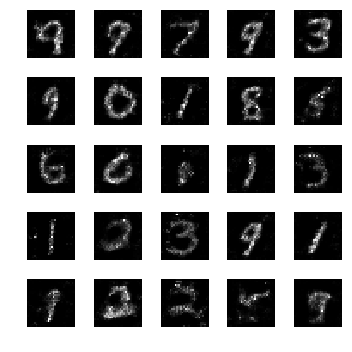

epoch: 761, time: 9.200082 | train_G_Loss: 0.404330, train_D_loss: 2.440479, train_acc: 0.925781
cv_G_Loss: 1.052649, cv_D_loss: 3.136018, cv_acc: 0.899300

epoch: 762, time: 8.445076 | train_G_Loss: 0.318207, train_D_loss: 2.248497, train_acc: 0.943359
cv_G_Loss: 0.344439, cv_D_loss: 2.436921, cv_acc: 0.905700

epoch: 763, time: 8.564931 | train_G_Loss: 0.412080, train_D_loss: 2.321059, train_acc: 0.933594
cv_G_Loss: 0.524628, cv_D_loss: 2.457039, cv_acc: 0.911300

epoch: 764, time: 9.438895 | train_G_Loss: 0.758245, train_D_loss: 2.449725, train_acc: 0.925781
cv_G_Loss: 1.416425, cv_D_loss: 3.833433, cv_acc: 0.898900

epoch: 765, time: 9.595521 | train_G_Loss: 0.581062, train_D_loss: 2.481189, train_acc: 0.892578
cv_G_Loss: 1.114764, cv_D_loss: 3.231270, cv_acc: 0.906200

epoch: 766, time: 9.678639 | train_G_Loss: 0.267586, train_D_loss: 2.599657, train_acc: 0.880859
cv_G_Loss: 0.172228, cv_D_loss: 2.650397, cv_acc: 0.909800

epoch: 767, time: 9.612150 | train_G_Loss: 0.304903, train

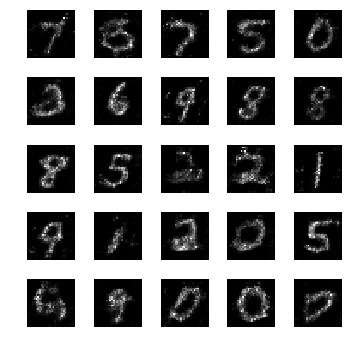

epoch: 771, time: 9.512996 | train_G_Loss: 0.348283, train_D_loss: 2.673996, train_acc: 0.900391
cv_G_Loss: 0.218867, cv_D_loss: 2.561887, cv_acc: 0.907500

epoch: 772, time: 9.669741 | train_G_Loss: 0.336578, train_D_loss: 2.352427, train_acc: 0.921875
cv_G_Loss: 0.146093, cv_D_loss: 2.751232, cv_acc: 0.906100

epoch: 773, time: 9.272890 | train_G_Loss: 0.448095, train_D_loss: 2.237660, train_acc: 0.900391
cv_G_Loss: 1.281997, cv_D_loss: 3.476825, cv_acc: 0.900800

epoch: 774, time: 9.524774 | train_G_Loss: 0.359524, train_D_loss: 2.445686, train_acc: 0.876953
cv_G_Loss: 0.209693, cv_D_loss: 2.550249, cv_acc: 0.909500

epoch: 775, time: 9.485540 | train_G_Loss: 0.352107, train_D_loss: 2.375417, train_acc: 0.878906
cv_G_Loss: 0.347006, cv_D_loss: 2.426831, cv_acc: 0.907000

epoch: 776, time: 9.579748 | train_G_Loss: 0.401552, train_D_loss: 2.614945, train_acc: 0.890625
cv_G_Loss: 0.675606, cv_D_loss: 2.605540, cv_acc: 0.911600

epoch: 777, time: 9.653919 | train_G_Loss: 0.307405, train

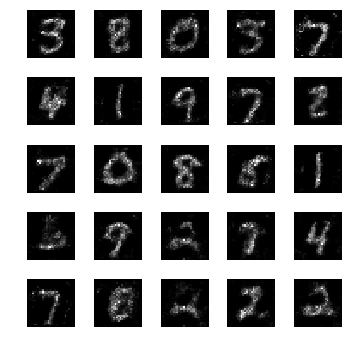

epoch: 781, time: 9.552900 | train_G_Loss: 0.310749, train_D_loss: 2.450084, train_acc: 0.925781
cv_G_Loss: 0.372919, cv_D_loss: 2.431804, cv_acc: 0.913800
Model saved

epoch: 782, time: 9.433693 | train_G_Loss: 0.412826, train_D_loss: 2.361663, train_acc: 0.925781
cv_G_Loss: 0.823955, cv_D_loss: 2.861145, cv_acc: 0.884800

epoch: 783, time: 9.294021 | train_G_Loss: 0.383964, train_D_loss: 2.435776, train_acc: 0.892578
cv_G_Loss: 0.534682, cv_D_loss: 2.516259, cv_acc: 0.909600

epoch: 784, time: 9.484905 | train_G_Loss: 0.317687, train_D_loss: 2.333221, train_acc: 0.890625
cv_G_Loss: 0.430240, cv_D_loss: 2.405314, cv_acc: 0.910900

epoch: 785, time: 9.513080 | train_G_Loss: 0.429946, train_D_loss: 2.385410, train_acc: 0.908203
cv_G_Loss: 0.427025, cv_D_loss: 2.407519, cv_acc: 0.912300

epoch: 786, time: 9.629422 | train_G_Loss: 0.273872, train_D_loss: 2.400517, train_acc: 0.904297
cv_G_Loss: 0.285223, cv_D_loss: 2.423850, cv_acc: 0.911800

epoch: 787, time: 9.548754 | train_G_Loss: 0.3

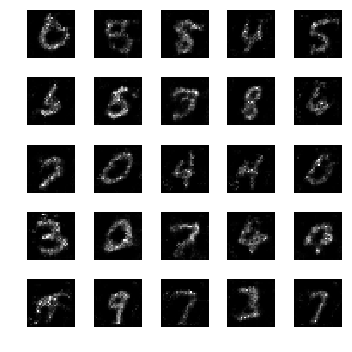

epoch: 791, time: 9.584888 | train_G_Loss: 0.326003, train_D_loss: 2.307977, train_acc: 0.931641
cv_G_Loss: 0.168331, cv_D_loss: 2.688271, cv_acc: 0.911500

epoch: 792, time: 9.585350 | train_G_Loss: 0.373976, train_D_loss: 2.405697, train_acc: 0.921875
cv_G_Loss: 0.807331, cv_D_loss: 2.696724, cv_acc: 0.908300

epoch: 793, time: 9.636414 | train_G_Loss: 0.362681, train_D_loss: 2.481128, train_acc: 0.917969
cv_G_Loss: 0.223791, cv_D_loss: 2.543535, cv_acc: 0.911800

epoch: 794, time: 9.572801 | train_G_Loss: 0.392877, train_D_loss: 2.478811, train_acc: 0.892578
cv_G_Loss: 0.636359, cv_D_loss: 2.571539, cv_acc: 0.909900

epoch: 795, time: 9.647434 | train_G_Loss: 0.389611, train_D_loss: 2.294509, train_acc: 0.931641
cv_G_Loss: 0.573919, cv_D_loss: 2.551410, cv_acc: 0.898800

epoch: 796, time: 9.342599 | train_G_Loss: 0.445005, train_D_loss: 2.244141, train_acc: 0.917969
cv_G_Loss: 0.617382, cv_D_loss: 2.517157, cv_acc: 0.914100
Model saved

epoch: 797, time: 9.663302 | train_G_Loss: 0.3

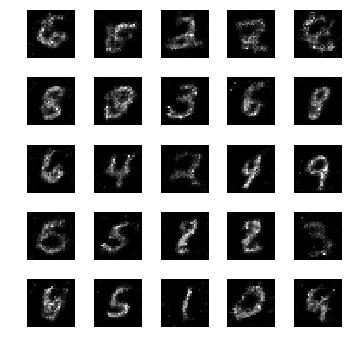

epoch: 801, time: 9.554861 | train_G_Loss: 0.392387, train_D_loss: 2.308909, train_acc: 0.927734
cv_G_Loss: 0.404036, cv_D_loss: 2.397050, cv_acc: 0.907700

epoch: 802, time: 9.526375 | train_G_Loss: 0.291595, train_D_loss: 2.657132, train_acc: 0.880859
cv_G_Loss: 0.512001, cv_D_loss: 2.462088, cv_acc: 0.898700

epoch: 803, time: 9.741481 | train_G_Loss: 0.329954, train_D_loss: 2.711656, train_acc: 0.896484
cv_G_Loss: 0.228817, cv_D_loss: 2.492175, cv_acc: 0.913000

epoch: 804, time: 9.646414 | train_G_Loss: 0.352572, train_D_loss: 2.314243, train_acc: 0.919922
cv_G_Loss: 0.608649, cv_D_loss: 2.508798, cv_acc: 0.913900

epoch: 805, time: 9.490438 | train_G_Loss: 0.348618, train_D_loss: 2.489916, train_acc: 0.919922
cv_G_Loss: 0.374888, cv_D_loss: 2.386402, cv_acc: 0.912700

epoch: 806, time: 9.367796 | train_G_Loss: 0.402501, train_D_loss: 2.266431, train_acc: 0.910156
cv_G_Loss: 0.262472, cv_D_loss: 2.481710, cv_acc: 0.906000

epoch: 807, time: 9.533997 | train_G_Loss: 0.330122, train

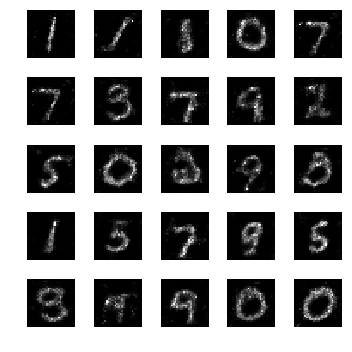

epoch: 811, time: 9.455500 | train_G_Loss: 0.467259, train_D_loss: 2.535611, train_acc: 0.892578
cv_G_Loss: 0.692747, cv_D_loss: 2.622066, cv_acc: 0.912000

epoch: 812, time: 9.441711 | train_G_Loss: 0.363640, train_D_loss: 2.397993, train_acc: 0.916016
cv_G_Loss: 0.144068, cv_D_loss: 2.749188, cv_acc: 0.907800

epoch: 813, time: 9.542120 | train_G_Loss: 0.383287, train_D_loss: 2.286677, train_acc: 0.919922
cv_G_Loss: 0.515838, cv_D_loss: 2.486605, cv_acc: 0.911900

epoch: 814, time: 9.578601 | train_G_Loss: 0.294999, train_D_loss: 2.325660, train_acc: 0.919922
cv_G_Loss: 0.508496, cv_D_loss: 2.425391, cv_acc: 0.911900

epoch: 815, time: 9.615593 | train_G_Loss: 0.300301, train_D_loss: 2.352304, train_acc: 0.921875
cv_G_Loss: 0.078192, cv_D_loss: 3.208905, cv_acc: 0.901000

epoch: 816, time: 9.544600 | train_G_Loss: 0.446913, train_D_loss: 2.421864, train_acc: 0.886719
cv_G_Loss: 0.597302, cv_D_loss: 2.499629, cv_acc: 0.916100
Model saved

epoch: 817, time: 9.632579 | train_G_Loss: 0.4

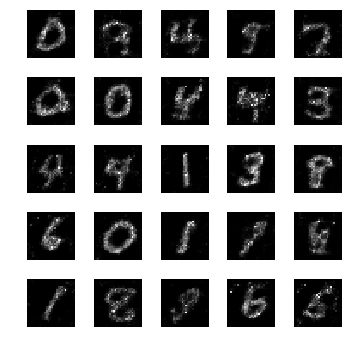

epoch: 821, time: 9.590281 | train_G_Loss: 0.435346, train_D_loss: 2.417908, train_acc: 0.929688
cv_G_Loss: 0.364662, cv_D_loss: 2.390903, cv_acc: 0.914300

epoch: 822, time: 9.765389 | train_G_Loss: 0.442544, train_D_loss: 2.316449, train_acc: 0.931641
cv_G_Loss: 0.807851, cv_D_loss: 2.724203, cv_acc: 0.910600

epoch: 823, time: 9.656285 | train_G_Loss: 0.357464, train_D_loss: 2.347146, train_acc: 0.923828
cv_G_Loss: 0.376976, cv_D_loss: 2.379903, cv_acc: 0.915000

epoch: 824, time: 9.545483 | train_G_Loss: 0.422254, train_D_loss: 2.425242, train_acc: 0.917969
cv_G_Loss: 0.355141, cv_D_loss: 2.384080, cv_acc: 0.918100
Model saved

epoch: 825, time: 9.461518 | train_G_Loss: 0.315801, train_D_loss: 2.408344, train_acc: 0.896484
cv_G_Loss: 0.202695, cv_D_loss: 2.532241, cv_acc: 0.916600

epoch: 826, time: 9.475580 | train_G_Loss: 0.343786, train_D_loss: 2.553041, train_acc: 0.910156
cv_G_Loss: 0.259368, cv_D_loss: 2.458729, cv_acc: 0.914100

epoch: 827, time: 9.516677 | train_G_Loss: 0.3

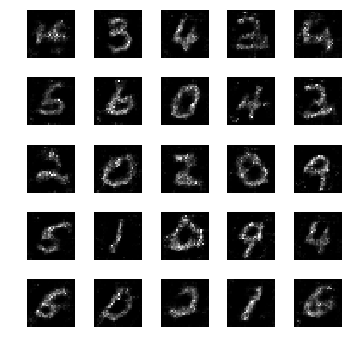

epoch: 831, time: 9.676334 | train_G_Loss: 0.317119, train_D_loss: 2.417021, train_acc: 0.880859
cv_G_Loss: 0.141965, cv_D_loss: 2.808023, cv_acc: 0.899500

epoch: 832, time: 9.474374 | train_G_Loss: 0.355425, train_D_loss: 2.384183, train_acc: 0.888672
cv_G_Loss: 0.444448, cv_D_loss: 2.437232, cv_acc: 0.913000

epoch: 833, time: 9.484182 | train_G_Loss: 0.339887, train_D_loss: 2.436302, train_acc: 0.894531
cv_G_Loss: 0.113331, cv_D_loss: 2.941333, cv_acc: 0.895200

epoch: 834, time: 9.442653 | train_G_Loss: 0.336844, train_D_loss: 2.595974, train_acc: 0.888672
cv_G_Loss: 0.324412, cv_D_loss: 2.418379, cv_acc: 0.915100

epoch: 835, time: 9.357988 | train_G_Loss: 0.289141, train_D_loss: 2.481051, train_acc: 0.878906
cv_G_Loss: 0.273741, cv_D_loss: 2.453800, cv_acc: 0.905000

epoch: 836, time: 9.548853 | train_G_Loss: 0.322262, train_D_loss: 2.636048, train_acc: 0.880859
cv_G_Loss: 1.012254, cv_D_loss: 3.061870, cv_acc: 0.878000

epoch: 837, time: 9.606929 | train_G_Loss: 0.443078, train

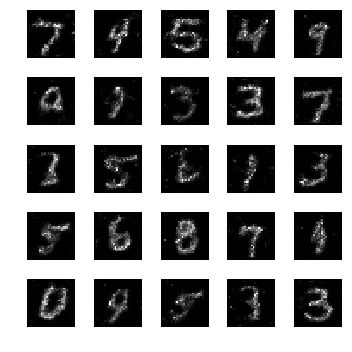

epoch: 841, time: 9.348961 | train_G_Loss: 0.292609, train_D_loss: 2.365113, train_acc: 0.955078
cv_G_Loss: 0.194071, cv_D_loss: 2.574326, cv_acc: 0.914500

epoch: 842, time: 9.463776 | train_G_Loss: 0.386509, train_D_loss: 2.446405, train_acc: 0.931641
cv_G_Loss: 0.463336, cv_D_loss: 2.453173, cv_acc: 0.908900

epoch: 843, time: 9.623003 | train_G_Loss: 0.342263, train_D_loss: 2.261757, train_acc: 0.906250
cv_G_Loss: 0.748408, cv_D_loss: 2.666993, cv_acc: 0.908800

epoch: 844, time: 9.533166 | train_G_Loss: 0.381543, train_D_loss: 2.465477, train_acc: 0.925781
cv_G_Loss: 0.373785, cv_D_loss: 2.371341, cv_acc: 0.916400

epoch: 845, time: 9.477564 | train_G_Loss: 0.350140, train_D_loss: 2.402925, train_acc: 0.929688
cv_G_Loss: 0.346610, cv_D_loss: 2.401861, cv_acc: 0.910800

epoch: 846, time: 9.478096 | train_G_Loss: 0.357979, train_D_loss: 2.521115, train_acc: 0.925781
cv_G_Loss: 0.300834, cv_D_loss: 2.418490, cv_acc: 0.915200

epoch: 847, time: 9.714748 | train_G_Loss: 0.432082, train

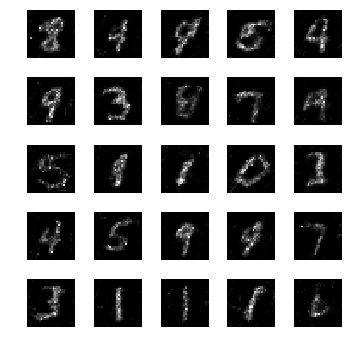

epoch: 851, time: 9.622204 | train_G_Loss: 0.372769, train_D_loss: 2.266913, train_acc: 0.914062
cv_G_Loss: 0.454715, cv_D_loss: 2.440785, cv_acc: 0.911300

epoch: 852, time: 9.530048 | train_G_Loss: 0.380115, train_D_loss: 2.307412, train_acc: 0.890625
cv_G_Loss: 0.437133, cv_D_loss: 2.392832, cv_acc: 0.915100

epoch: 853, time: 9.578748 | train_G_Loss: 0.455551, train_D_loss: 2.488924, train_acc: 0.882812
cv_G_Loss: 0.312937, cv_D_loss: 2.443024, cv_acc: 0.909600

epoch: 854, time: 9.324828 | train_G_Loss: 0.413608, train_D_loss: 2.445424, train_acc: 0.921875
cv_G_Loss: 0.554666, cv_D_loss: 2.454485, cv_acc: 0.914400

epoch: 855, time: 9.595079 | train_G_Loss: 0.355173, train_D_loss: 2.357924, train_acc: 0.923828
cv_G_Loss: 0.154390, cv_D_loss: 2.682684, cv_acc: 0.917000

epoch: 856, time: 9.049864 | train_G_Loss: 0.360663, train_D_loss: 2.283986, train_acc: 0.917969
cv_G_Loss: 0.390152, cv_D_loss: 2.431069, cv_acc: 0.907700

epoch: 857, time: 9.439043 | train_G_Loss: 0.513459, train

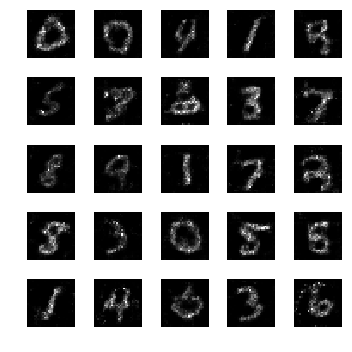

epoch: 861, time: 9.433025 | train_G_Loss: 0.370865, train_D_loss: 2.401140, train_acc: 0.912109
cv_G_Loss: 0.339238, cv_D_loss: 2.398223, cv_acc: 0.918500
Model saved

epoch: 862, time: 9.641290 | train_G_Loss: 0.447260, train_D_loss: 2.418958, train_acc: 0.916016
cv_G_Loss: 0.329396, cv_D_loss: 2.484019, cv_acc: 0.898400

epoch: 863, time: 9.591962 | train_G_Loss: 0.387311, train_D_loss: 2.405786, train_acc: 0.927734
cv_G_Loss: 0.385963, cv_D_loss: 2.441802, cv_acc: 0.910800

epoch: 864, time: 9.302180 | train_G_Loss: 0.387476, train_D_loss: 2.347752, train_acc: 0.929688
cv_G_Loss: 0.425112, cv_D_loss: 2.374691, cv_acc: 0.917600

epoch: 865, time: 9.545457 | train_G_Loss: 0.278791, train_D_loss: 2.409246, train_acc: 0.929688
cv_G_Loss: 0.124933, cv_D_loss: 2.889478, cv_acc: 0.898100

epoch: 866, time: 9.586077 | train_G_Loss: 0.332182, train_D_loss: 2.366138, train_acc: 0.896484
cv_G_Loss: 0.229418, cv_D_loss: 2.508672, cv_acc: 0.912600

epoch: 867, time: 9.551601 | train_G_Loss: 0.3

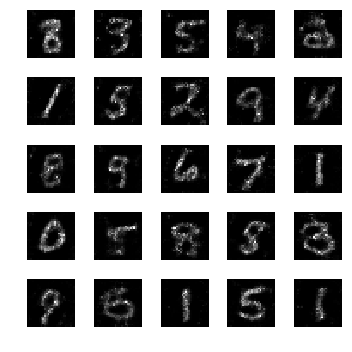

epoch: 871, time: 9.574538 | train_G_Loss: 0.325959, train_D_loss: 2.277993, train_acc: 0.908203
cv_G_Loss: 0.345205, cv_D_loss: 2.387674, cv_acc: 0.917800

epoch: 872, time: 9.588792 | train_G_Loss: 0.289039, train_D_loss: 2.478227, train_acc: 0.914062
cv_G_Loss: 0.180087, cv_D_loss: 2.592152, cv_acc: 0.917900

epoch: 873, time: 9.626002 | train_G_Loss: 0.393490, train_D_loss: 2.489112, train_acc: 0.935547
cv_G_Loss: 0.865489, cv_D_loss: 2.833713, cv_acc: 0.906400

epoch: 874, time: 9.462755 | train_G_Loss: 0.399402, train_D_loss: 2.324434, train_acc: 0.935547
cv_G_Loss: 0.178838, cv_D_loss: 2.661181, cv_acc: 0.902200

epoch: 875, time: 9.660446 | train_G_Loss: 0.387179, train_D_loss: 2.476041, train_acc: 0.892578
cv_G_Loss: 0.335143, cv_D_loss: 2.397252, cv_acc: 0.916000

epoch: 876, time: 9.725508 | train_G_Loss: 0.335024, train_D_loss: 2.570338, train_acc: 0.896484
cv_G_Loss: 0.636536, cv_D_loss: 2.551155, cv_acc: 0.910300

epoch: 877, time: 9.622421 | train_G_Loss: 0.362440, train

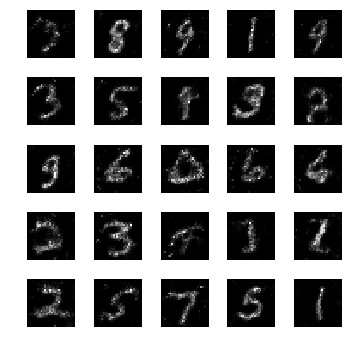

epoch: 881, time: 9.651804 | train_G_Loss: 0.342486, train_D_loss: 2.411340, train_acc: 0.892578
cv_G_Loss: 0.400510, cv_D_loss: 2.455266, cv_acc: 0.911500

epoch: 882, time: 9.537843 | train_G_Loss: 0.223093, train_D_loss: 2.771922, train_acc: 0.896484
cv_G_Loss: 0.146029, cv_D_loss: 2.768800, cv_acc: 0.900800

epoch: 883, time: 9.571230 | train_G_Loss: 0.385724, train_D_loss: 2.354554, train_acc: 0.910156
cv_G_Loss: 0.798765, cv_D_loss: 2.740800, cv_acc: 0.910000

epoch: 884, time: 9.475676 | train_G_Loss: 0.436415, train_D_loss: 2.272287, train_acc: 0.927734
cv_G_Loss: 0.334072, cv_D_loss: 2.435911, cv_acc: 0.914100

epoch: 885, time: 9.620144 | train_G_Loss: 0.492212, train_D_loss: 2.286771, train_acc: 0.908203
cv_G_Loss: 1.069082, cv_D_loss: 3.159898, cv_acc: 0.915000

epoch: 886, time: 9.344386 | train_G_Loss: 0.340012, train_D_loss: 2.189736, train_acc: 0.904297
cv_G_Loss: 0.200965, cv_D_loss: 2.566351, cv_acc: 0.914500

epoch: 887, time: 9.351372 | train_G_Loss: 0.349022, train

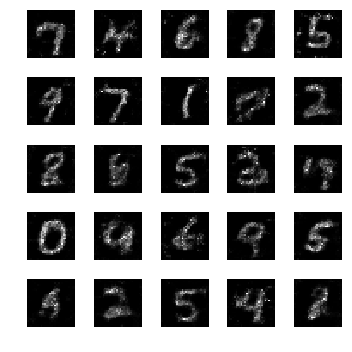

epoch: 891, time: 9.647356 | train_G_Loss: 0.334846, train_D_loss: 2.431548, train_acc: 0.914062
cv_G_Loss: 0.287379, cv_D_loss: 2.430058, cv_acc: 0.917000

epoch: 892, time: 9.577574 | train_G_Loss: 0.285101, train_D_loss: 2.358510, train_acc: 0.908203
cv_G_Loss: 0.258166, cv_D_loss: 2.443362, cv_acc: 0.920100
Model saved

epoch: 893, time: 9.332320 | train_G_Loss: 0.306881, train_D_loss: 2.384061, train_acc: 0.894531
cv_G_Loss: 0.162752, cv_D_loss: 2.665626, cv_acc: 0.916900

epoch: 894, time: 9.607931 | train_G_Loss: 0.366171, train_D_loss: 2.305060, train_acc: 0.882812
cv_G_Loss: 0.391912, cv_D_loss: 2.395674, cv_acc: 0.916200

epoch: 895, time: 9.459562 | train_G_Loss: 0.650436, train_D_loss: 2.471838, train_acc: 0.927734
cv_G_Loss: 1.867841, cv_D_loss: 4.497594, cv_acc: 0.909700

epoch: 896, time: 9.675707 | train_G_Loss: 0.384808, train_D_loss: 2.447075, train_acc: 0.902344
cv_G_Loss: 0.281971, cv_D_loss: 2.461338, cv_acc: 0.909700

epoch: 897, time: 9.541510 | train_G_Loss: 0.3

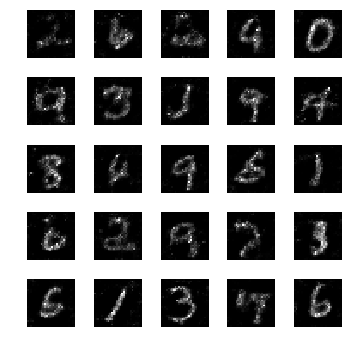

epoch: 901, time: 9.513182 | train_G_Loss: 0.397271, train_D_loss: 2.356733, train_acc: 0.937500
cv_G_Loss: 0.644687, cv_D_loss: 2.552833, cv_acc: 0.918000

epoch: 902, time: 9.626621 | train_G_Loss: 0.269697, train_D_loss: 2.283216, train_acc: 0.904297
cv_G_Loss: 0.133317, cv_D_loss: 2.770831, cv_acc: 0.918500

epoch: 903, time: 9.608384 | train_G_Loss: 0.248277, train_D_loss: 2.775758, train_acc: 0.916016
cv_G_Loss: 0.164318, cv_D_loss: 2.659185, cv_acc: 0.921200
Model saved

epoch: 904, time: 9.511683 | train_G_Loss: 0.410514, train_D_loss: 2.324095, train_acc: 0.927734
cv_G_Loss: 0.429639, cv_D_loss: 2.411726, cv_acc: 0.917700

epoch: 905, time: 9.641577 | train_G_Loss: 0.336000, train_D_loss: 2.621728, train_acc: 0.888672
cv_G_Loss: 0.434279, cv_D_loss: 2.402300, cv_acc: 0.916000

epoch: 906, time: 9.636905 | train_G_Loss: 0.385352, train_D_loss: 2.456436, train_acc: 0.923828
cv_G_Loss: 0.246000, cv_D_loss: 2.504075, cv_acc: 0.907800

epoch: 907, time: 9.641182 | train_G_Loss: 0.3

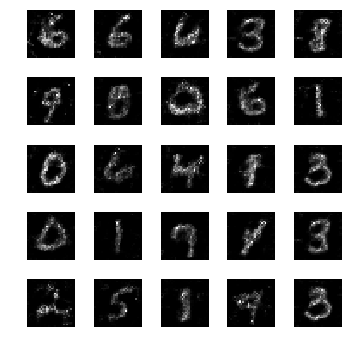

epoch: 911, time: 9.549500 | train_G_Loss: 0.511833, train_D_loss: 2.324565, train_acc: 0.908203
cv_G_Loss: 0.798469, cv_D_loss: 2.740889, cv_acc: 0.914500

epoch: 912, time: 9.554943 | train_G_Loss: 0.272330, train_D_loss: 2.307086, train_acc: 0.912109
cv_G_Loss: 0.484165, cv_D_loss: 2.452615, cv_acc: 0.915400

epoch: 913, time: 9.663733 | train_G_Loss: 0.411488, train_D_loss: 2.237057, train_acc: 0.927734
cv_G_Loss: 0.628896, cv_D_loss: 2.501358, cv_acc: 0.916600

epoch: 914, time: 9.629676 | train_G_Loss: 0.368946, train_D_loss: 2.424046, train_acc: 0.939453
cv_G_Loss: 0.320849, cv_D_loss: 2.431979, cv_acc: 0.914500

epoch: 915, time: 9.336271 | train_G_Loss: 0.341960, train_D_loss: 2.312775, train_acc: 0.937500
cv_G_Loss: 0.304966, cv_D_loss: 2.413775, cv_acc: 0.916900

epoch: 916, time: 9.644822 | train_G_Loss: 0.404087, train_D_loss: 2.150883, train_acc: 0.943359
cv_G_Loss: 0.651109, cv_D_loss: 2.623179, cv_acc: 0.911300

epoch: 917, time: 9.556225 | train_G_Loss: 0.427023, train

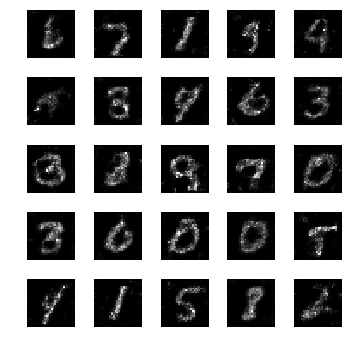

epoch: 921, time: 9.628376 | train_G_Loss: 0.399703, train_D_loss: 2.295648, train_acc: 0.923828
cv_G_Loss: 0.224187, cv_D_loss: 2.631229, cv_acc: 0.886700

epoch: 922, time: 9.380086 | train_G_Loss: 0.496621, train_D_loss: 2.654119, train_acc: 0.945312
cv_G_Loss: 0.673605, cv_D_loss: 2.555017, cv_acc: 0.922200
Model saved

epoch: 923, time: 9.390476 | train_G_Loss: 0.446946, train_D_loss: 2.190848, train_acc: 0.953125
cv_G_Loss: 0.479497, cv_D_loss: 2.436390, cv_acc: 0.918500

epoch: 924, time: 9.544457 | train_G_Loss: 0.401058, train_D_loss: 2.265538, train_acc: 0.951172
cv_G_Loss: 0.489014, cv_D_loss: 2.443372, cv_acc: 0.920100

epoch: 925, time: 9.341594 | train_G_Loss: 0.361970, train_D_loss: 2.235550, train_acc: 0.968750
cv_G_Loss: 0.674190, cv_D_loss: 2.592910, cv_acc: 0.918800

epoch: 926, time: 9.577322 | train_G_Loss: 0.421107, train_D_loss: 2.122640, train_acc: 0.968750
cv_G_Loss: 0.549510, cv_D_loss: 2.606640, cv_acc: 0.895700

epoch: 927, time: 9.601177 | train_G_Loss: 0.5

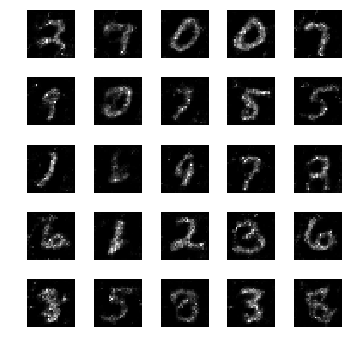

epoch: 931, time: 9.362038 | train_G_Loss: 0.350857, train_D_loss: 2.456783, train_acc: 0.921875
cv_G_Loss: 0.472323, cv_D_loss: 2.471099, cv_acc: 0.910000

epoch: 932, time: 9.541241 | train_G_Loss: 0.384186, train_D_loss: 2.369869, train_acc: 0.947266
cv_G_Loss: 0.474233, cv_D_loss: 2.403681, cv_acc: 0.920500

epoch: 933, time: 9.629166 | train_G_Loss: 0.338454, train_D_loss: 2.263779, train_acc: 0.968750
cv_G_Loss: 0.209686, cv_D_loss: 2.546573, cv_acc: 0.912300

epoch: 934, time: 9.577764 | train_G_Loss: 0.343245, train_D_loss: 2.432301, train_acc: 0.941406
cv_G_Loss: 0.251568, cv_D_loss: 2.473024, cv_acc: 0.918000

epoch: 935, time: 9.626148 | train_G_Loss: 0.383375, train_D_loss: 2.197143, train_acc: 0.916016
cv_G_Loss: 0.843085, cv_D_loss: 2.820401, cv_acc: 0.915800

epoch: 936, time: 9.565303 | train_G_Loss: 0.303466, train_D_loss: 2.545070, train_acc: 0.902344
cv_G_Loss: 0.353609, cv_D_loss: 2.472781, cv_acc: 0.900700

epoch: 937, time: 9.326731 | train_G_Loss: 0.364998, train

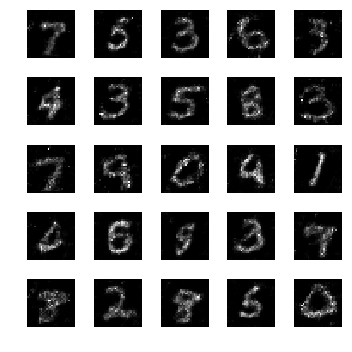

epoch: 941, time: 9.659889 | train_G_Loss: 0.377702, train_D_loss: 2.293946, train_acc: 0.896484
cv_G_Loss: 0.365462, cv_D_loss: 2.383921, cv_acc: 0.919300

epoch: 942, time: 9.669744 | train_G_Loss: 0.378123, train_D_loss: 2.539283, train_acc: 0.886719
cv_G_Loss: 1.132610, cv_D_loss: 3.255303, cv_acc: 0.913300

epoch: 943, time: 9.560387 | train_G_Loss: 0.291001, train_D_loss: 2.432459, train_acc: 0.925781
cv_G_Loss: 0.167697, cv_D_loss: 2.632807, cv_acc: 0.916900

epoch: 944, time: 9.317496 | train_G_Loss: 0.457695, train_D_loss: 2.547279, train_acc: 0.921875
cv_G_Loss: 0.676914, cv_D_loss: 2.586792, cv_acc: 0.916500

epoch: 945, time: 9.680110 | train_G_Loss: 0.351463, train_D_loss: 2.343509, train_acc: 0.927734
cv_G_Loss: 0.719952, cv_D_loss: 2.681264, cv_acc: 0.914300

epoch: 946, time: 9.596078 | train_G_Loss: 0.451803, train_D_loss: 2.192771, train_acc: 0.910156
cv_G_Loss: 0.599235, cv_D_loss: 2.593677, cv_acc: 0.904300

epoch: 947, time: 9.471362 | train_G_Loss: 0.358326, train

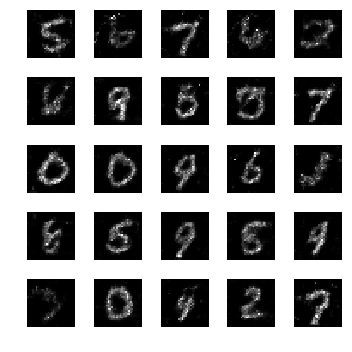

epoch: 951, time: 9.450382 | train_G_Loss: 0.374902, train_D_loss: 2.244925, train_acc: 0.894531
cv_G_Loss: 0.339103, cv_D_loss: 2.384636, cv_acc: 0.922000

epoch: 952, time: 9.760551 | train_G_Loss: 0.351848, train_D_loss: 2.544029, train_acc: 0.892578
cv_G_Loss: 0.680045, cv_D_loss: 2.579316, cv_acc: 0.919400

epoch: 953, time: 9.629285 | train_G_Loss: 0.355141, train_D_loss: 2.372429, train_acc: 0.923828
cv_G_Loss: 0.270143, cv_D_loss: 2.501102, cv_acc: 0.902700

epoch: 954, time: 9.574758 | train_G_Loss: 0.454747, train_D_loss: 2.461230, train_acc: 0.906250
cv_G_Loss: 0.824086, cv_D_loss: 2.763536, cv_acc: 0.910000

epoch: 955, time: 9.632224 | train_G_Loss: 0.322858, train_D_loss: 2.517520, train_acc: 0.912109
cv_G_Loss: 0.404494, cv_D_loss: 2.380979, cv_acc: 0.921500

epoch: 956, time: 9.540766 | train_G_Loss: 0.533247, train_D_loss: 2.498072, train_acc: 0.896484
cv_G_Loss: 0.971083, cv_D_loss: 2.948617, cv_acc: 0.920400

epoch: 957, time: 9.398064 | train_G_Loss: 0.295320, train

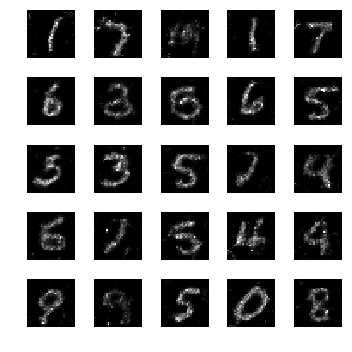

epoch: 961, time: 9.659440 | train_G_Loss: 0.367652, train_D_loss: 2.477452, train_acc: 0.888672
cv_G_Loss: 0.964185, cv_D_loss: 2.953420, cv_acc: 0.906300

epoch: 962, time: 9.558620 | train_G_Loss: 0.314702, train_D_loss: 2.641644, train_acc: 0.896484
cv_G_Loss: 0.838457, cv_D_loss: 2.796632, cv_acc: 0.911000

epoch: 963, time: 9.466024 | train_G_Loss: 0.370256, train_D_loss: 2.382973, train_acc: 0.941406
cv_G_Loss: 0.206911, cv_D_loss: 2.521408, cv_acc: 0.921300

epoch: 964, time: 9.330235 | train_G_Loss: 0.477373, train_D_loss: 2.459461, train_acc: 0.927734
cv_G_Loss: 3.075011, cv_D_loss: 7.047721, cv_acc: 0.752300

epoch: 965, time: 9.464811 | train_G_Loss: 0.378743, train_D_loss: 2.351992, train_acc: 0.908203
cv_G_Loss: 0.451564, cv_D_loss: 2.390926, cv_acc: 0.920300

epoch: 966, time: 9.722509 | train_G_Loss: 0.332592, train_D_loss: 2.776634, train_acc: 0.894531
cv_G_Loss: 0.859261, cv_D_loss: 2.778399, cv_acc: 0.911200

epoch: 967, time: 9.597521 | train_G_Loss: 0.339512, train

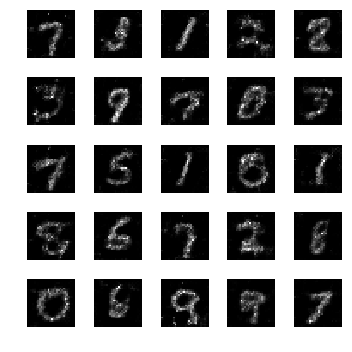

epoch: 971, time: 9.606492 | train_G_Loss: 0.427936, train_D_loss: 2.541752, train_acc: 0.910156
cv_G_Loss: 1.887607, cv_D_loss: 4.605102, cv_acc: 0.884900

epoch: 972, time: 9.558268 | train_G_Loss: 0.321185, train_D_loss: 2.447275, train_acc: 0.910156
cv_G_Loss: 0.559222, cv_D_loss: 2.451776, cv_acc: 0.922400

epoch: 973, time: 9.401317 | train_G_Loss: 0.374518, train_D_loss: 2.428955, train_acc: 0.929688
cv_G_Loss: 0.597525, cv_D_loss: 2.499873, cv_acc: 0.910100

epoch: 974, time: 9.531911 | train_G_Loss: 0.467277, train_D_loss: 2.313037, train_acc: 0.943359
cv_G_Loss: 0.952263, cv_D_loss: 2.931539, cv_acc: 0.915700

epoch: 975, time: 9.535570 | train_G_Loss: 0.309716, train_D_loss: 2.453622, train_acc: 0.925781
cv_G_Loss: 0.377346, cv_D_loss: 2.349036, cv_acc: 0.923300

epoch: 976, time: 9.527133 | train_G_Loss: 0.446160, train_D_loss: 2.379311, train_acc: 0.943359
cv_G_Loss: 0.637537, cv_D_loss: 2.528040, cv_acc: 0.921400

epoch: 977, time: 9.656317 | train_G_Loss: 0.410693, train

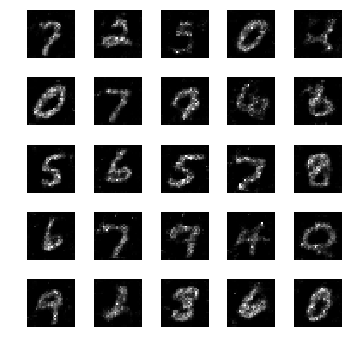

epoch: 981, time: 9.608077 | train_G_Loss: 0.368561, train_D_loss: 2.605900, train_acc: 0.927734
cv_G_Loss: 0.385573, cv_D_loss: 2.362828, cv_acc: 0.923200

epoch: 982, time: 9.567733 | train_G_Loss: 0.369667, train_D_loss: 2.130900, train_acc: 0.910156
cv_G_Loss: 0.581390, cv_D_loss: 2.472946, cv_acc: 0.921700

epoch: 983, time: 9.504962 | train_G_Loss: 0.317204, train_D_loss: 2.474248, train_acc: 0.917969
cv_G_Loss: 0.549093, cv_D_loss: 2.443975, cv_acc: 0.919300

epoch: 984, time: 9.542400 | train_G_Loss: 0.373480, train_D_loss: 2.226469, train_acc: 0.937500
cv_G_Loss: 0.397522, cv_D_loss: 2.362185, cv_acc: 0.918800

epoch: 985, time: 9.592496 | train_G_Loss: 0.468485, train_D_loss: 2.472275, train_acc: 0.941406
cv_G_Loss: 0.420482, cv_D_loss: 2.380396, cv_acc: 0.920200

epoch: 986, time: 9.243741 | train_G_Loss: 0.381120, train_D_loss: 2.313824, train_acc: 0.947266
cv_G_Loss: 0.322211, cv_D_loss: 2.416881, cv_acc: 0.910700

epoch: 987, time: 9.530831 | train_G_Loss: 0.410660, train

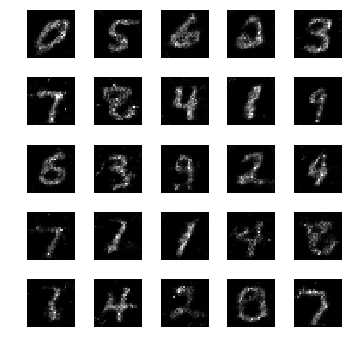

epoch: 991, time: 9.578078 | train_G_Loss: 0.392833, train_D_loss: 2.260213, train_acc: 0.931641
cv_G_Loss: 0.712203, cv_D_loss: 2.603583, cv_acc: 0.917300

epoch: 992, time: 9.430927 | train_G_Loss: 0.395720, train_D_loss: 2.346795, train_acc: 0.912109
cv_G_Loss: 0.101585, cv_D_loss: 3.003633, cv_acc: 0.901600

epoch: 993, time: 9.455764 | train_G_Loss: 0.313335, train_D_loss: 2.466487, train_acc: 0.916016
cv_G_Loss: 0.468734, cv_D_loss: 2.402389, cv_acc: 0.913500

epoch: 994, time: 9.565225 | train_G_Loss: 0.264027, train_D_loss: 2.445209, train_acc: 0.910156
cv_G_Loss: 0.246756, cv_D_loss: 2.422183, cv_acc: 0.923900

epoch: 995, time: 9.547793 | train_G_Loss: 0.399324, train_D_loss: 2.220019, train_acc: 0.910156
cv_G_Loss: 0.354098, cv_D_loss: 2.356958, cv_acc: 0.925500
Model saved

epoch: 996, time: 9.469411 | train_G_Loss: 0.332251, train_D_loss: 2.562648, train_acc: 0.900391
cv_G_Loss: 0.264064, cv_D_loss: 2.444325, cv_acc: 0.919500

epoch: 997, time: 9.476637 | train_G_Loss: 0.4

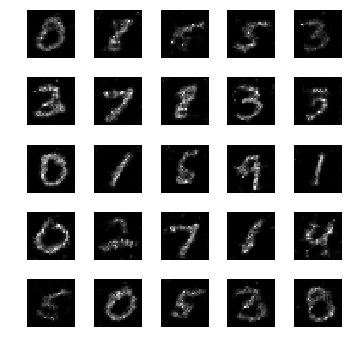

In [ ]:
loss_acc = train_SSL_GAN(512, 1001)